New:
 - Hc divided into 3 subsamples
 - PU/PV additional tracks ratio corrected

In [1]:
fit_real_data = False
category = 'low'
SM_RDst = 0.33
fastRun = False
card_name = 'v8_'+category

# Import

In [2]:
import sys, os, pickle, time
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')
from categoriesDef import categories
import itertools
import commands
from prettytable import PrettyTable
import json, yaml
from IPython.display import IFrame, Image, display

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from array import array

import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from pT_calibration_reader import pTCalReader
from histo_utilities import create_TH1D, create_TH2D, std_color_list
from gridVarQ2Plot import plot_gridVarQ2, plot_SingleCategory
from progressBar import ProgressBar
from lumi_utilities import getLumiByTrigger
from combine_utilities import getUncertaintyFromLimitTree, dumpDiffNuisances, stringJubCustomizationCaltechT2

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1

if fit_real_data:
    CMS_lumi.extraText = "     Preliminary"
else:
    CMS_lumi.extraText = "     Simulation Preliminary"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [4]:
cat = categories[category]

# Load the datasets

In [5]:
#They all have to be produced with the same pileup
MCsample = {
'mu' : DSetLoader('B0_MuNuDmst_PUc0'),
'tau' : DSetLoader('B0_TauNuDmst_PUc0'),
'DstmD0' : DSetLoader('B0_DstmD0_PUc0'),
'DstmDp' : DSetLoader('B0_DstmDp_PUc0'),
'DstmDsp' : DSetLoader('B0_DstmDsp_PUc0'),
'BpDstmHc' : DSetLoader('Bp_DstmHc_PUc0'),
'BmDstmHc' : DSetLoader('Bm_DstmHc_PUc0'),
'antiB0DstmHc' : DSetLoader('antiB0_DstmHc_PUc0'),
'DstPip' : DSetLoader('Bp_MuNuDstst_Pip_PUc0'),
'DstPi0' : DSetLoader('B0_MuNuDstst_Pi0_PUc0'),
'DstPipPi0' : DSetLoader('Bp_MuNuDstst_PipPi0_PUc0'),
'DstPipPim' : DSetLoader('B0_MuNuDstst_PipPim_PUc0'),
'DstPi0Pi0' : DSetLoader('B0_MuNuDstst_Pi0Pi0_PUc0'),
}
dSet = {}
dSetTkSide = {}
for n, s in MCsample.iteritems():
    dSet[n] = rtnp.root2array(s.skimmed_dir + '/{}_corr.root'.format(cat.name))
    dSetTkSide[n] = rtnp.root2array(s.skimmed_dir + '/{}_trkCtrl_corr.root'.format(cat.name))

In [6]:
if fit_real_data:
    creation_date = '200515'
    locRD = '../data/cmsRD/skimmed/B2DstMu_{}_{}'.format(creation_date, cat.name)
    dSet['data'] = rtnp.root2array(locRD + '_corr.root')
    dSetTkSide['data'] = rtnp.root2array(locRD + '_trkCtrl_corr.root')
    dataDir = '../data/cmsRD'
    datasets_loc = glob(dataDir + '/ParkingBPH*/*RDntuplizer_B2DstMu_{}_CAND.root'.format(creation_date))
    lumi_tot = getLumiByTrigger(datasets_loc, cat.trg, verbose=True)
    CMS_lumi.integrated_lumi = lumi_tot
else:
    expectedLumi = {'low':6., 'mid':20., 'high':26., 'single':6.} #fb^-1
    lumi_tot = expectedLumi[category]

# Load all the calibrations

Pileup

In [7]:
# loc = '../data/cmsRD/ParkingBPH{}/Run2018D-05May2019promptD-v1_RDntuplizer_PrescaleVertices_200515_CAND.root'
# fAuxPileupRD = []

# hPileupTarget = None

# for i in range(1, 6):
#     fAuxPileupRD.append(rt.TFile.Open(loc.format(i), 'READ'))
#     if hPileupTarget is None:
#         hPileupTarget = fAuxPileupRD[-1].Get('nVtx/hNvtxPassed'+cat.trg).Clone()
#     else:
#         hPileupTarget.Add(fAuxPileupRD[-1].Get('nVtx/hNvtxPassed'+cat.trg))

# hPileupTarget.Scale(1./hPileupTarget.Integral())

# fAuxPileupMC = rt.TFile.Open(MCsample['mu'].skimmed_dir + '/{}_corr.root'.format(cat.name), 'READ')
# hPileupGen = fAuxPileupMC.Get('hAllNvtx')
# hPileupGen.Scale(1./hPileupGen.Integral())

# weights = np.ones(hPileupGen.GetNbinsX())
# s = 0
# for i in range(weights.shape[0]):
#     if hPileupGen.GetBinContent(i+1) == 0:
#         continue
#     weights[i] = hPileupTarget.GetBinContent(i+1)/hPileupGen.GetBinContent(i+1)
#     s += hPileupGen.GetBinContent(i+1) * weights[i]

# weightsPileupMC = weights/s

# for f in fAuxPileupRD + [fAuxPileupMC]:
#     f.Close()

# def getPileupWeights(ds, selection=None):
#     x = ds['N_vtx']
#     if not selection is None:
#         x = x[selection]
#     return weightsPileupMC[x.astype(np.int)]

from pileup_utilities import pileupReweighter
puReweighter = pileupReweighter(MCsample['mu'].skimmed_dir + '/{}_corr.root'.format(cat.name), cat)

Total norm pre-scale

In [8]:
r = np.zeros((3,2))
for i, fn in enumerate(glob('../data/calibration/totalRate/ratioB02JPsiKst_*.txt')):
    with open(fn, 'r') as faux:
        aux = faux.readlines()[0][:-1].split(' ')
        r[i] = [float(aux[0]), float(aux[1])]
s2 = np.square(r[:,1])
num = np.sum(r[:,0]/s2)
den = np.sum(1./s2)
RDoMC_normRatio = [num/den, np.sqrt(1/den)]
print 'Expected ratio between RD and MC norm: {:.3f} +/- {:.3f}'.format(RDoMC_normRatio[0], RDoMC_normRatio[1])

Expected ratio between RD and MC norm: 2.729 +/- 0.065


Branching fraction

In [9]:
decayBR = pickle.load(open('../data/forcedDecayChannelsFactors.pickle', 'rb'))

Trigger scale factor

In [10]:
loc = '../data/calibration/triggerScaleFactors/'
fTriggerSF = rt.TFile.Open(loc + 'HLT_' + cat.trg + '_SF_v3.root', 'READ')
hTriggerSF = fTriggerSF.Get('hSF_HLT_' + cat.trg)

In [11]:
def computeTrgSF(ds, selection=None):
    trgSF = np.ones_like(ds['q2'])
    trgSFUnc = np.zeros_like(ds['q2'])
    if not fastRun:
        ptmax = hTriggerSF.GetXaxis().GetXmax() - 0.01
        ipmax = hTriggerSF.GetYaxis().GetXmax() - 0.01
        etamax = hTriggerSF.GetZaxis().GetXmax() - 0.01
        x = np.column_stack((ds['mu_pt'], ds['mu_eta'], ds['mu_sigdxy']))
        if not selection is None:
            x = x[selection]
        for i, (pt, eta, ip) in enumerate(x):
            ix = hTriggerSF.GetXaxis().FindBin(min(ptmax, pt))
            iy = hTriggerSF.GetYaxis().FindBin(min(ipmax, ip))
            iz = hTriggerSF.GetZaxis().FindBin(min(etamax, np.abs(eta)))
            trgSF[i] = hTriggerSF.GetBinContent(ix, iy, iz)
            ib = hTriggerSF.GetBin(ix, iy, iz)
            trgSFUnc[i] = hTriggerSF.GetBinError(ib)
            if trgSF[i] == 0:
                print pt, ip, np.abs(eta)
                raise
    # Divide them for the weight so later you can simply multiply back to get the value
    up = 1 + trgSFUnc/trgSF
    down = 1 - trgSFUnc/trgSF
    return trgSF, up, down

Muon ID scale factors

In [12]:
fMuonIDSF = rt.TFile.Open('../data/calibration/muonIDscaleFactors/Run2018ABCD_SF_MuonID_Jpsi.root', 'READ')
hMuonIDSF = fMuonIDSF.Get('NUM_SoftID_DEN_genTracks_pt_abseta')

In [13]:
def computeMuonIDSF(ds, selection=None):
    muonSF = np.ones_like(ds['q2'])
    muonSFUnc = np.zeros_like(ds['q2'])
    if not fastRun:
        ptmax = hMuonIDSF.GetXaxis().GetXmax() - 0.01
        etamax = hMuonIDSF.GetYaxis().GetXmax() - 0.01
        x = np.column_stack((ds['MC_mu_pt'], ds['MC_mu_eta']))
        if not selection is None:
            x = x[selection]
        for i, (pt, eta) in enumerate(x):
            ix = hMuonIDSF.GetXaxis().FindBin(min(pt, ptmax))
            if ix == 0: ix = 1 #Remove underflows (Meaning that the MC matching failed)
            iy = hMuonIDSF.GetYaxis().FindBin(min(np.abs(eta), etamax))
            muonSF[i] = hMuonIDSF.GetBinContent(ix, iy)
            muonSFUnc[i] = hMuonIDSF.GetBinError(hMuonIDSF.GetBin(ix, iy))
            if muonSF[i] == 0:
                print pt, eta
                print ix, iy
                raise
    up = 1 + muonSFUnc/muonSF
    down = 1 - muonSFUnc/muonSF
    return muonSF, up, down

B transverse momentum calibration

In [14]:
aux = 'Low' if category == 'single' else cat.name
cal_pT = pTCalReader(calibration_file='../data/calibration/B0pTspectrum/pwWeights_{}.txt'.format(aux))

In [15]:
def computeB0pTweights(ds):
    # The denominator (sum of weights) for this weights is not known but it cancel out in the ratio
    w = cal_pT.f['C'](ds['MC_B_pt'])
    if np.sum(w==0):
        print np.sum(w==0)
        raise
    up = cal_pT.f['Up'](ds['MC_B_pt'])/w
    down = cal_pT.f['Down'](ds['MC_B_pt'])/w
    return w, up, down

In [16]:
def computeBrVarWeights(ds, selItems={}, relScale=0.2, keepNorm=False):
    sel = np.ones_like(ds['mu_pt']).astype(np.bool)
    for var, val in selItems.iteritems():
        sel = np.logical_and(ds[var].astype(np.int) == val, sel)
    w = np.ones_like(sel)
    up = np.where(sel, 1.+relScale, 1.)
    down = np.where(sel, max(0, 1.-relScale), 1.)
    if keepNorm:
        up = float(up.shape[0])/np.sum(up)
        down = float(down.shape[0])/np.sum(down)
    return w, up, down

In [17]:
def computeTksPVweights(ds, relScale=0.05, centralVal=0.39/0.10):
    selPdgID0 = np.logical_and(np.abs(ds['MC_tkMotherPdgId_0']) < 6, ds['MC_tkMotherPdgId_0'] != 0)
    selPdgID0 = np.logical_or(selPdgID0, ds['MC_tkMotherPdgId_0']==2212)
    selPdgID0 = np.logical_and(selPdgID0, ds['MC_tkFlag_0'] == 1)
    selPdgID1 = np.logical_and(np.abs(ds['MC_tkMotherPdgId_1']) < 6, ds['MC_tkMotherPdgId_1'] != 0)
    selPdgID1 = np.logical_or(selPdgID1, ds['MC_tkMotherPdgId_1']==2212)
    selPdgID1 = np.logical_and( selPdgID1, ds['MC_tkFlag_1'] == 1)
    exponent = selPdgID0.astype(np.int) + selPdgID1.astype(np.int)
    w = np.power(centralVal, exponent)
    up = np.power(centralVal*(1+relScale), exponent)/w
    down = np.power(centralVal*(1-relScale), exponent)/w
    return w, up, down

# Create MC histograms

### Signal region

In [18]:
binning = {
    'M2_miss' : [
        array('d', [-2.5] + list(np.arange(-1.8, -0.2, 0.4)) + [-0.2, 0., 0.2, 0.6, 8] ),
        array('d', [-2.5] + list(np.arange(-1.8, -0.1, 0.4)) + [-0.1, 0.0, 0.1, 0.2, 0.3] + list(np.arange(0.4, 3.0, 0.4)) + [8] ),
        array('d', [-2.5] + list(np.arange(-1.8, 5.6, 0.4)) + [8] ),
        array('d', [-2.5] + list(np.arange(-1.8, 7.6, 0.4)) + [8] ),
    ],
    'Est_mu'  : [
        array('d', [0.3] + list(np.arange(0.7, 2.3, 0.1)) + [2.5] ),
        array('d', [0.3] + list(np.arange(0.7, 2.5, 0.1)) + [2.5] ),
        array('d', [0.3] + list(np.arange(0.5, 2.5, 0.1)) + [2.5] ),
        [22, 0.3, 2.500],
    ],
}
if fit_real_data:
#     binning['q2'] = array('d', [-2, 2.5, 6, 9.4, 12])
    binning['q2'] = array('d', [-2, 2.5, 6])
else:
    binning['q2'] = array('d', [-2, 2.5, 6, 9.4, 12])

In [19]:
histo = {}
for n, ds in dSet.iteritems():
    if n == 'data': continue
    print '\n----------->', n, '<-------------'
    sMC = MCsample[n]
    
    nTotSelected = ds['q2'].shape[0]
    print 'N tot selected: {:.1f}k'.format(1e-3*nTotSelected)
    nGenExp = sMC.effMCgen['xsec'][0] * lumi_tot * RDoMC_normRatio[0]
    eff = [1, 0]
    for f, df in [sMC.effMCgen['effGEN'], decayBR[n], sMC.effCand['effCAND'], sMC.getSkimEff(cat.name+'_corr')]:
        eff[0] *= f
        eff[1] += np.square(df/f)
    eff[1] = eff[0] * np.sqrt(eff[1])
    nTotExp = nGenExp*eff[0]
    print 'N tot expected (before weights): {:.2f}k'.format(1e-3*nTotExp)
    
    wVar = {}
    weights = {}
    
    print 'Including pileup reweighting'
    weights['pileup'] = puReweighter.weightsPileupMC[ds['N_vtx'].astype(np.int)]
#     weights['pileup'] = getPileupWeights(ds)
    print 'Including trigger corrections'
    weights['trgSF'], wVar['trgSFUp'], wVar['trgSFDown'] = computeTrgSF(ds)
    print 'Including muon ID corrections'
    weights['muonIdSF'], wVar['muonIdSFUp'], wVar['muonIdSFDown'] = computeMuonIDSF(ds)
    if n in ['mu', 'tau', 'DstmD0', 'DstmDp', 'DstmDsp','DstPi0', 'DstPipPim', 'DstPi0Pi0']: #B0 dominated final states (probably we should do something about B+ too)
        print 'Including B0 pT corrections'
        weights['B0pT'], wVar['B0pTUp'], wVar['B0pTDown'] = computeB0pTweights(ds)
    # Hammer corrections to the FF
    if n in ['mu', 'tau']:
        print 'Including FF corrections (Hammer)'
        weights['B2DstCLN'] = ds['wh_CLNCentral']*sMC.effCand['rate_den']/sMC.effCand['rate_Central']
        for nPar in ['R0', 'R1', 'R2', 'RhoSq']:
            for var in ['Up', 'Down']:
                tag = 'CLN' + nPar + var
                wVar['B2Dst'+tag] = ds['wh_'+tag]/sMC.effCand['rate_' + nPar + var]
                wVar['B2Dst'+tag] *= sMC.effCand['rate_Central']/ds['wh_CLNCentral']
    #Dstst resonance mix
    if n == 'DstPip':
        _, wVar['fDststWideUp'], wVar['fDststWideDown'] = computeBrVarWeights(ds, {'MC_munuSisterPdgId': -20423}, 0.6/2.7, keepNorm=True) #Gamma 14 pdg 2020
    #Hc mix variations
    if n == 'DstmD0':
        _, wVar['BrB02DstD0KpUp'], wVar['BrB02DstD0KpDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 421, 'MC_DstSisterPdgId_light': 321}, 0.21/2.47) #Gamma 169 pdg 2020
        _, wVar['BrB02DstD0KstpUp'], wVar['BrB02DstD0KstpDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 421, 'MC_DstSisterPdgId_light': 323}, 0.5) # Guess
        _, wVar['BrB02DstDst0KpUp'], wVar['BrB02DstDst0KpDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 423, 'MC_DstSisterPdgId_light': 321}, 0.09/1.06) #Gamma 170 pdg 2020
        _, wVar['BrB02DstDst0KstpUp'], wVar['BrB02DstDst0KstpDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 423, 'MC_DstSisterPdgId_light': 323}, 0.5) # Guess
        _, wVar['BrB02DstDstpK0Up'], wVar['BrB02DstDstpK0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 413, 'MC_DstSisterPdgId_light': 311}, 0.5/5.3) #Gamma 173 pdg 2020
        _, wVar['BrB02DstDstpKst0Up'], wVar['BrB02DstDstpKst0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 413, 'MC_DstSisterPdgId_light': 313}, 0.5) # Guess
    if n == 'DstmDp':
        _, wVar['BrB02DstDpK0Up'], wVar['BrB02DstDpK0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 411, 'MC_DstSisterPdgId_light': 311}, 0.5/3.2) #Gamma 172 pdg 2020
        _, wVar['BrB02DstDpKst0Up'], wVar['BrB02DstDpKst0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 411, 'MC_DstSisterPdgId_light': 313}, 0.5) # Guess
        _, wVar['BrB02DstDstpK0Up'], wVar['BrB02DstDstpK0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 413, 'MC_DstSisterPdgId_light': 311}, 0.2/2.7) #Gamma 173 pdg 2020
        _, wVar['BrB02DstDstpKst0Up'], wVar['BrB02DstDstpKst0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 413, 'MC_DstSisterPdgId_light': 313}, 0.5) # Guess
    if n == 'DstmDsp':
        _, wVar['BrB02DstDsUp'], wVar['BrB02DstDsDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 431}, 1.1/8.0) #Gamma 83 pdg 2020
        _, wVar['BrB02DstDsstUp'], wVar['BrB02DstDsstDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 433}, .14/1.77) #Gamma 85 pdg 2020
        _, wVar['BrB02DstDs0stUp'], wVar['BrB02DstDs0stDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 10431}, .6/1.5) #Gamma 95 pdg 2020
    
    print 'Computing total weights'
    weightsCentral = np.ones_like(ds['q2'])
    for w in weights.values(): weightsCentral *= w
    print 'N tot expected (after weights): {:.2f}k'.format(1e-3*nTotExp*np.sum(weightsCentral)/nTotSelected)
    wVar[''] = np.ones_like(weightsCentral)
    
    for i_q2 in range(len(binning['q2'])-1):
        q2_l = binning['q2'][i_q2]
        q2_h = binning['q2'][i_q2 + 1]
        sel_q2 = np.logical_and(ds['q2'] > q2_l, ds['q2'] < q2_h)
        for var in ['M2_miss', 'Est_mu']:
            cat_name = var+'_q2bin'+str(i_q2)
            
            if not cat_name in histo.keys():
                histo[cat_name] = {}
            
            for name_wVar, v_wVar in wVar.iteritems():
                h_name = n
                if not name_wVar == '':
                    h_name += '__' + name_wVar
                w = weightsCentral*v_wVar
                scale = nTotExp/nTotSelected
                histo[cat_name][h_name] = create_TH1D(
                                                      ds[var][sel_q2], 
                                                      name=h_name, title=h_name, 
                                                      binning=binning[var][i_q2], 
                                                      opt='underflow,overflow',
                                                      weights=w[sel_q2], scale_histo=scale,
                                                      )


-----------> tau <-------------
N tot selected: 61.3k
N tot expected (before weights): 5.93k
Including pileup reweighting
Including trigger corrections
Including muon ID corrections
Including B0 pT corrections
Including FF corrections (Hammer)
Computing total weights
N tot expected (after weights): 6.73k

-----------> DstmD0 <-------------
N tot selected: 0.8k
N tot expected (before weights): 0.04k
Including pileup reweighting
Including trigger corrections
Including muon ID corrections
Including B0 pT corrections
Computing total weights
N tot expected (after weights): 0.04k

-----------> BmDstmHc <-------------
N tot selected: 1.1k
N tot expected (before weights): 0.08k
Including pileup reweighting
Including trigger corrections
Including muon ID corrections
Computing total weights
N tot expected (after weights): 0.09k

-----------> DstPipPi0 <-------------
N tot selected: 3.4k
N tot expected (before weights): 0.38k
Including pileup reweighting
Including trigger corrections
Including m

### Single track side

In [20]:
sideSelecton = {}
sideVar = {}
sideXtitle = {}
sideAddtext = {}

def selfun__TkPlus(ds):
    sel = np.logical_and(ds['N_goodAddTks'] == 1, ds['tkCharge_0'] > 0)
    return sel
#     return np.logical_and(np.abs(ds['tkMassHad_0'] - 2.43) < 0.3, sel)
sideSelecton['AddTk_p_mHad'] = selfun__TkPlus
sideVar['AddTk_p_mHad'] = 'tkMassHad_0'
binning['AddTk_p_mHad'] = [35, 2.13, 2.83]
sideXtitle['AddTk_p_mHad'] = 'Total hadrons mass'
sideAddtext['AddTk_p_mHad'] = 'N_{tk} = 1 & Q_{tk} = +1'

def selfun__TkMinus(ds):
    sel = np.logical_and(ds['N_goodAddTks'] == 1, ds['tkCharge_0'] < 0)
    return sel
sideSelecton['AddTk_m_mHad'] = selfun__TkMinus
sideVar['AddTk_m_mHad'] = 'tkMassHad_0'
binning['AddTk_m_mHad'] = [30, 2.1, 3.3]
sideXtitle['AddTk_m_mHad'] = 'Total hadrons mass'
sideAddtext['AddTk_m_mHad'] = 'N_{tk} = 1 & Q_{tk} = -1'

# sideSelecton['AddTk_m_tkPt'] = selfun__TkMinus
# sideVar['AddTk_m_tkPt'] = 'tkPt_0'
# binning['AddTk_m_tkPt'] = np.logspace(np.log10(0.5), np.log10(5.0), 30)
# sideXtitle['AddTk_m_tkPt'] = 'Additional track p_{T}'
# sideAddtext['AddTk_m_tkPt'] = 'N_{tk} = 1 & Q_{tk} = -1'


def selfun__TkPlusMinus(ds):
    sel = np.logical_and(ds['tkCharge_0']+ds['tkCharge_1'] == 0, ds['N_goodAddTks'] == 2)
    sel = np.logical_and(ds['tkMassVis12'] < 5.3, sel)
    return sel
sideSelecton['AddTk_pm_mVis'] = selfun__TkPlusMinus
sideVar['AddTk_pm_mVis'] = 'tkMassVis12'
binning['AddTk_pm_mVis'] = array('d', [2.8] + list(np.arange(3., 5.3, 0.1)) + [5.3] )
sideXtitle['AddTk_pm_mVis'] = 'Total visible mass'
sideAddtext['AddTk_pm_mVis'] = 'N_{tk} = 2 & #sumQ_{tk} = 0'


sideSelecton['AddTk_pm_mHad'] = selfun__TkPlusMinus
sideVar['AddTk_pm_mHad'] = 'tkMassHad12'
binning['AddTk_pm_mHad'] = [30, 2.3, 3.75]
sideXtitle['AddTk_pm_mHad'] = 'Total hadrons mass'
sideAddtext['AddTk_pm_mHad'] = 'N_{tk} = 2 & #sumQ_{tk} = 0'

def selfun__TkMinusMinus(ds):
    sel = np.logical_and(ds['tkCharge_0']+ds['tkCharge_1'] == -2, ds['N_goodAddTks'] == 2)
    sel = np.logical_and(ds['tkMassVis12'] < 5.3, sel)
    return sel
sideSelecton['AddTk_mm_mHad'] = selfun__TkMinusMinus
sideVar['AddTk_mm_mHad'] = 'tkMassHad12'
binning['AddTk_mm_mHad'] = [15, 2.25, 3.6]
sideXtitle['AddTk_mm_mHad'] = 'Total hadrons mass'
sideAddtext['AddTk_mm_mHad'] = 'N_{tk} = 2 & #sumQ_{tk} = -2'

def selfun__TkPlusPlus(ds):
    sel = np.logical_and(ds['tkCharge_0']+ds['tkCharge_1'] == +2, ds['N_goodAddTks'] == 2)
    sel = np.logical_and(ds['tkMassVis12'] < 5.3, sel)
    return sel
sideSelecton['AddTk_pp_mHad'] = selfun__TkPlusPlus
sideVar['AddTk_pp_mHad'] = 'tkMassHad12'
binning['AddTk_pp_mHad'] = [15, 2.25, 3.75]
sideXtitle['AddTk_pp_mHad'] = 'Total hadrons mass'
sideAddtext['AddTk_pp_mHad'] = 'N_{tk} = 2 & #sumQ_{tk} = +2'

In [21]:
for k in sideSelecton.keys():
    histo[k] = {}

for n, ds in dSetTkSide.iteritems():
    if n == 'data': continue
    print '\n----------->', n, '<-------------'
    sMC = MCsample[n]    
    wVar = {}
    weights = {}
    
    print 'Including pileup reweighting'
    weights['pileup'] = puReweighter.weightsPileupMC[ds['N_vtx'].astype(np.int)]
#     weights['pileup'] = getPileupWeights(ds)
    print 'Including trigger corrections'
    weights['trgSF'], wVar['trgSFUp'], wVar['trgSFDown'] = computeTrgSF(ds)
    print 'Including muon ID corrections'
    weights['muonIdSF'], wVar['muonIdSFUp'], wVar['muonIdSFDown'] = computeMuonIDSF(ds)
    if n in ['mu', 'tau', 'DstmD0', 'DstmDp', 'DstmDsp','DstPi0', 'DstPipPim', 'DstPi0Pi0']: #B0 dominated final states (probably we should do something about B+ too)
        print 'Including B0 pT corrections'
        weights['B0pT'], wVar['B0pTUp'], wVar['B0pTDown'] = computeB0pTweights(ds)
    # Hammer corrections to the FF
    if n in ['mu', 'tau']:
        print 'Including FF corrections (Hammer)'
        weights['B2DstCLN'] = ds['wh_CLNCentral']*sMC.effCand['rate_den']/sMC.effCand['rate_Central']
        for nPar in ['R0', 'R1', 'R2', 'RhoSq']:
            for var in ['Up', 'Down']:
                tag = 'CLN' + nPar + var
                wVar['B2Dst'+tag] = ds['wh_'+tag]/sMC.effCand['rate_' + nPar + var]
                wVar['B2Dst'+tag] *= sMC.effCand['rate_Central']/ds['wh_CLNCentral']
    #Dstst resonance mix
    if n == 'DstPip':
        _, wVar['fDststWideUp'], wVar['fDststWideDown'] = computeBrVarWeights(ds, {'MC_munuSisterPdgId': -20423}, 0.6/2.7, keepNorm=True) #Gamma 14 pdg 2020
    #Hc mix variations
    if n == 'DstmD0':
        _, wVar['BrB02DstD0KpUp'], wVar['BrB02DstD0KpDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 421, 'MC_DstSisterPdgId_light': 321}, 0.21/2.47) #Gamma 169 pdg 2020
        _, wVar['BrB02DstD0KstpUp'], wVar['BrB02DstD0KstpDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 421, 'MC_DstSisterPdgId_light': 323}, 0.5) # Guess
        _, wVar['BrB02DstDst0KpUp'], wVar['BrB02DstDst0KpDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 423, 'MC_DstSisterPdgId_light': 321}, 0.09/1.06) #Gamma 170 pdg 2020
        _, wVar['BrB02DstDst0KstpUp'], wVar['BrB02DstDst0KstpDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 423, 'MC_DstSisterPdgId_light': 323}, 0.5) # Guess
        _, wVar['BrB02DstDstpK0Up'], wVar['BrB02DstDstpK0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 413, 'MC_DstSisterPdgId_light': 311}, 0.5/5.3) #Gamma 173 pdg 2020
        _, wVar['BrB02DstDstpKst0Up'], wVar['BrB02DstDstpKst0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 413, 'MC_DstSisterPdgId_light': 313}, 0.5) # Guess
    if n == 'DstmDp':
        _, wVar['BrB02DstDpK0Up'], wVar['BrB02DstDpK0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 411, 'MC_DstSisterPdgId_light': 311}, 0.5/3.2) #Gamma 172 pdg 2020
        _, wVar['BrB02DstDpKst0Up'], wVar['BrB02DstDpKst0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 411, 'MC_DstSisterPdgId_light': 313}, 0.5) # Guess
        _, wVar['BrB02DstDstpK0Up'], wVar['BrB02DstDstpK0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 413, 'MC_DstSisterPdgId_light': 311}, 0.2/2.7) #Gamma 173 pdg 2020
        _, wVar['BrB02DstDstpKst0Up'], wVar['BrB02DstDstpKst0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 413, 'MC_DstSisterPdgId_light': 313}, 0.5) # Guess
    if n == 'DstmDsp':
        _, wVar['BrB02DstDsUp'], wVar['BrB02DstDsDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 431}, 1.1/8.0) #Gamma 83 pdg 2020
        _, wVar['BrB02DstDsstUp'], wVar['BrB02DstDsstDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 433}, .14/1.77) #Gamma 85 pdg 2020
        _, wVar['BrB02DstDs0stUp'], wVar['BrB02DstDs0stDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 10431}, .6/1.5) #Gamma 95 pdg 2020
        
    # Correct the amount of random tracks from PV
    weights['tkPVfrac'], wVar['tkPVfracUp'], wVar['tkPVfracDown'] = computeTksPVweights(ds)
    
    print 'Computing total weights'
    weightsCentral = np.ones_like(ds['q2'])
    for w in weights.values(): 
        weightsCentral *= w
    wVar[''] = np.ones_like(weightsCentral)
    
    nGenExp = sMC.effMCgen['xsec'][0] * lumi_tot * RDoMC_normRatio[0]
    eff = [1, 0]
    for f, df in [sMC.effMCgen['effGEN'], 
                  decayBR[n], 
                  sMC.effCand['effCAND'], 
                  sMC.getSkimEff(cat.name+'_trkCtrl_corr'),
                 ]:
        eff[0] *= f
        eff[1] += np.square(df/f)
    eff[1] = eff[0] * np.sqrt(eff[1])
    nTotExp = nGenExp*eff[0]
    
    sel = {}
    scale = {}
    
    for k, selFun in sideSelecton.iteritems():
        sel[k] = selFun(ds)
        nTotSel = float(np.sum(sel[k]))
        print 'N tot selected {}: {:.0f}'.format(k, nTotSel)
        nExp = nTotExp * nTotSel / sel[k].shape[0]
        print 'N tot expected {} (before weights): {:.0f}'.format(k, nExp)
        nAux = nTotExp * np.sum(weightsCentral[sel[k]]) / sel[k].shape[0]
        print 'N tot expected {} (after weights): {:.0f}'.format(k, nAux)
        scale[k] = nExp/nTotSel
    
            
    for name_wVar, v_wVar in wVar.iteritems():
        h_name = n
        if not name_wVar == '':
            h_name += '__' + name_wVar
        w = weightsCentral*v_wVar
        
        for k in sideVar.keys():
            histo[k][h_name] = create_TH1D(
                                           ds[sideVar[k]][sel[k]], 
                                           name=h_name, title=h_name, 
                                           binning=binning[k],
                                           opt='underflow',
                                           weights=w[sel[k]], scale_histo=scale[k]
                                          )


-----------> tau <-------------
Including pileup reweighting
Including trigger corrections
Including muon ID corrections
Including B0 pT corrections
Including FF corrections (Hammer)
Computing total weights
N tot selected AddTk_pm_mHad: 148
N tot expected AddTk_pm_mHad (before weights): 14
N tot expected AddTk_pm_mHad (after weights): 39
N tot selected AddTk_m_mHad: 1883
N tot expected AddTk_m_mHad (before weights): 182
N tot expected AddTk_m_mHad (after weights): 260
N tot selected AddTk_p_mHad: 2160
N tot expected AddTk_p_mHad (before weights): 209
N tot expected AddTk_p_mHad (after weights): 311
N tot selected AddTk_pp_mHad: 68
N tot expected AddTk_pp_mHad (before weights): 7
N tot expected AddTk_pp_mHad (after weights): 14
N tot selected AddTk_mm_mHad: 51
N tot expected AddTk_mm_mHad (before weights): 5
N tot expected AddTk_mm_mHad (after weights): 10
N tot selected AddTk_pm_mVis: 148
N tot expected AddTk_pm_mVis (before weights): 14
N tot expected AddTk_pm_mVis (after weights): 3

Including muon ID corrections
Including B0 pT corrections
Computing total weights
N tot selected AddTk_pm_mHad: 5920
N tot expected AddTk_pm_mHad (before weights): 787
N tot expected AddTk_pm_mHad (after weights): 903
N tot selected AddTk_m_mHad: 2771
N tot expected AddTk_m_mHad (before weights): 368
N tot expected AddTk_m_mHad (after weights): 402
N tot selected AddTk_p_mHad: 3188
N tot expected AddTk_p_mHad (before weights): 424
N tot expected AddTk_p_mHad (after weights): 457
N tot selected AddTk_pp_mHad: 116
N tot expected AddTk_pp_mHad (before weights): 15
N tot expected AddTk_pp_mHad (after weights): 24
N tot selected AddTk_mm_mHad: 76
N tot expected AddTk_mm_mHad (before weights): 10
N tot expected AddTk_mm_mHad (after weights): 12
N tot selected AddTk_pm_mVis: 5920
N tot expected AddTk_pm_mVis (before weights): 787
N tot expected AddTk_pm_mVis (after weights): 903

-----------> DstmDp <-------------
Including pileup reweighting
Including trigger corrections
Including muon ID co

# Create (pseudo-)data histogram

In [22]:
if fit_real_data:
    ds = dSet['data']
    print 'N observed data: {:.1f}k'.format(1e-3*ds['q2'].shape[0])
    for i_q2 in range(len(binning['q2'])-1):
        q2_l = binning['q2'][i_q2]
        q2_h = binning['q2'][i_q2 + 1]
        sel_q2 = np.logical_and(ds['q2'] > q2_l, ds['q2'] < q2_h)
        for var in ['M2_miss', 'Est_mu']:
            cat_name = var+'_q2bin'+str(i_q2)     
            histo[cat_name]['data'] = create_TH1D(
                                                  ds[var][sel_q2], 
                                                  name='data_obs', title='Data Obs',
                                                  binning=binning[var][i_q2],
                                                  opt='underflow,overflow'
                                                 )
    ds = dSetTkSide['data']
    for k in sideVar.keys():
        histo[k]['data'] = create_TH1D(
                                       ds[sideVar[k]][sideSelecton[k](ds)], 
                                       name='data_obs', title='Data Obs', 
                                       binning=binning[k],
                                       opt='underflow',
                                      )
        
else:
    for i_q2 in range(len(binning['q2'])-1):
        for var in ['M2_miss', 'Est_mu']:
            cat_name = var+'_q2bin'+str(i_q2)
            
            h = create_TH1D(np.array([0, 0]), name='data_obs', title='Data Obs', binning=binning[var][i_q2])
            h.Reset()
            for n, hMC in histo[cat_name].iteritems():
                if not '__' in n and not n == 'data':
                    scale = SM_RDst if 'tau' in n else 1.
                    h.Add(hMC, scale)
            h.Sumw2(0)
            for i in range(1, h.GetNbinsX()+1):
                h.SetBinContent(i, np.around(h.GetBinContent(i)))
            h.Sumw2()
            histo[cat_name]['data'] = h
            
    for k in sideVar.keys():
        h = create_TH1D(np.array([0, 0]), name='data_obs', title='Data Obs', 
                        binning=binning[k])
        h.Reset()
        for n, hMC in histo[k].iteritems():
            if not '__' in n and not n == 'data':
                scale = SM_RDst if 'tau' in n else 1.
                h.Add(hMC, scale)
        h.Sumw2(0)
        for i in range(1, h.GetNbinsX()+1):
            h.SetBinContent(i, np.around(h.GetBinContent(i)))
        h.Sumw2()
        histo[k]['data'] = h

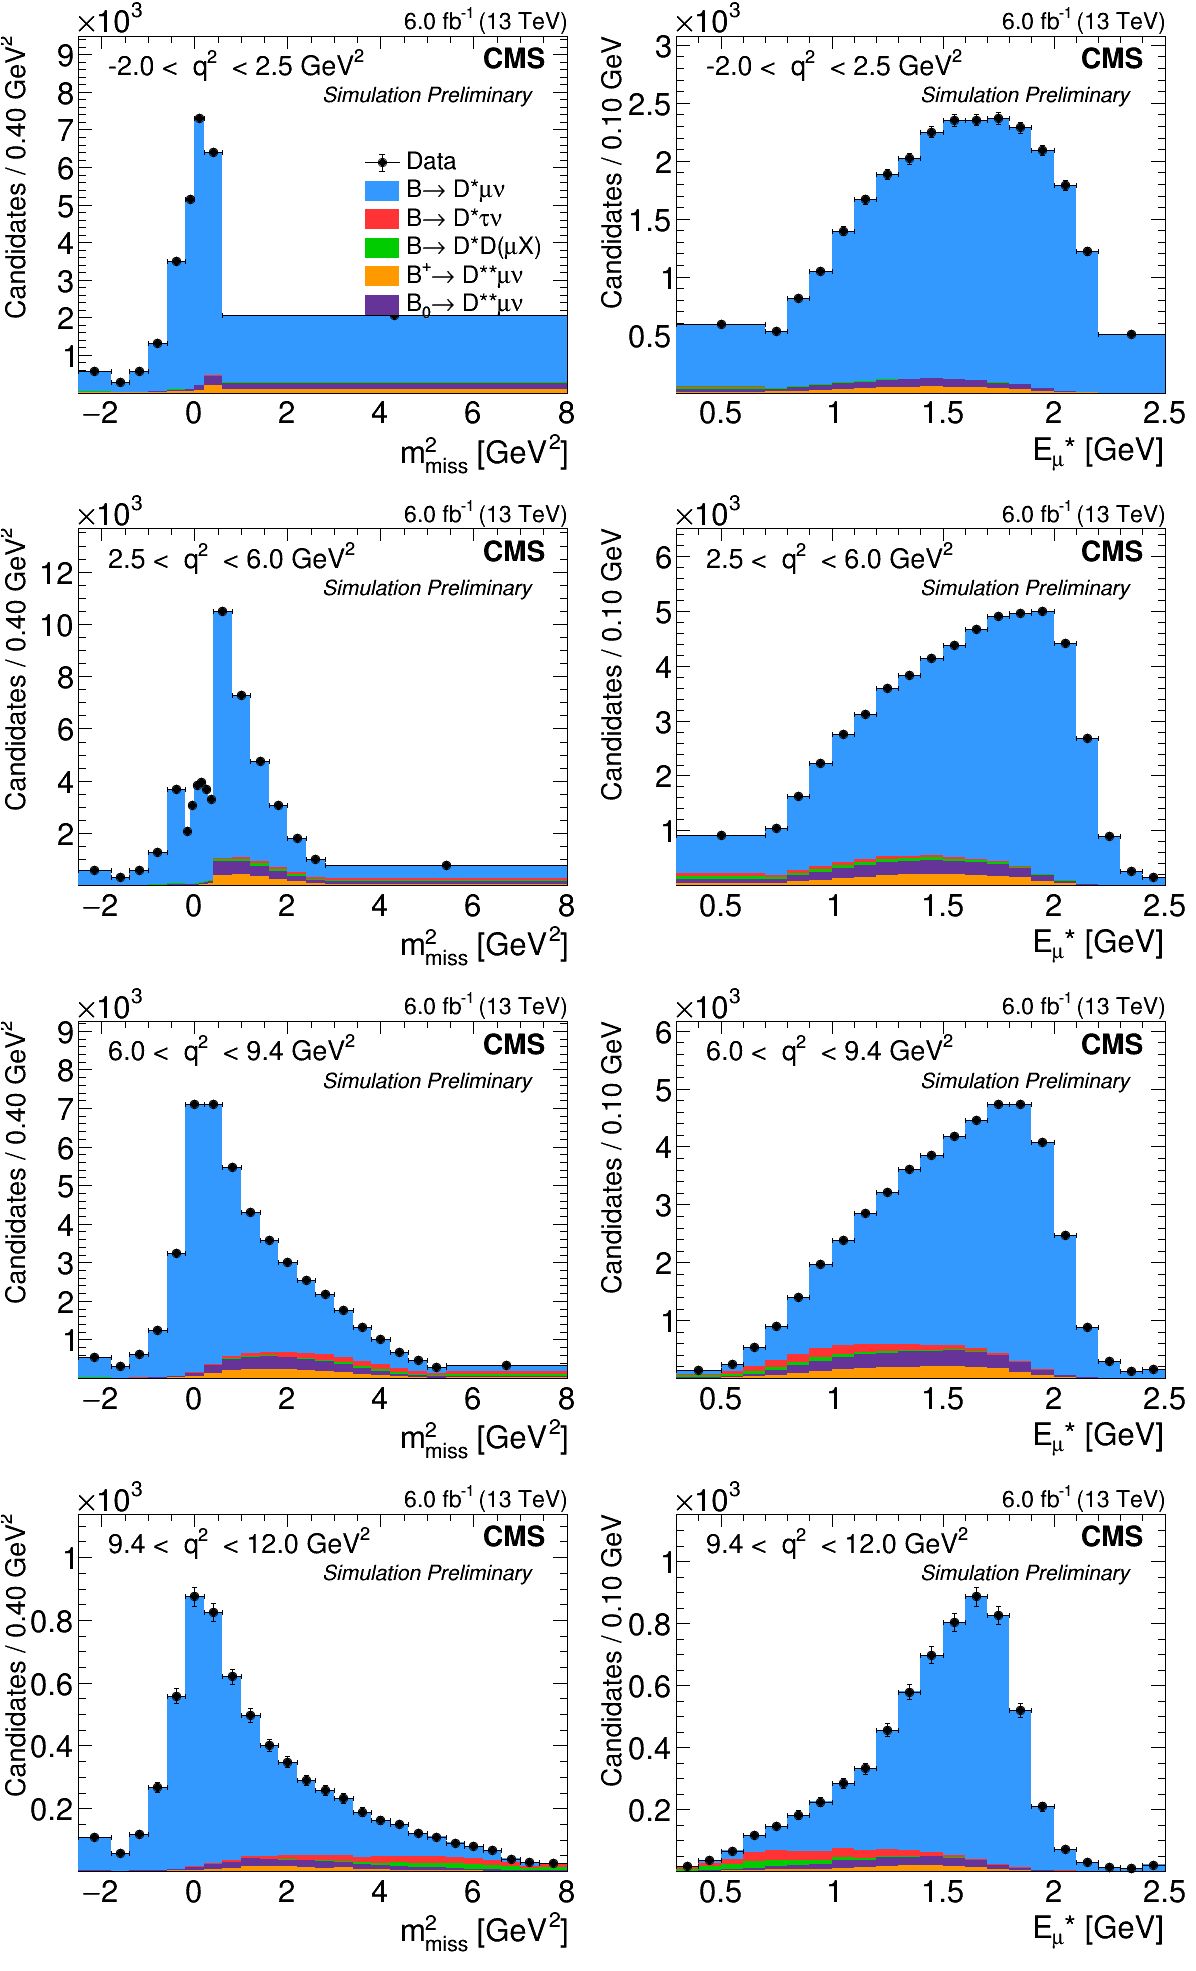

In [23]:
CMS_lumi.integrated_lumi = lumi_tot
scale_dic = {'tau': SM_RDst
            }

cSigPre = plot_gridVarQ2(CMS_lumi, binning, histo, scale_dic=scale_dic, min_y=1, logy=False)

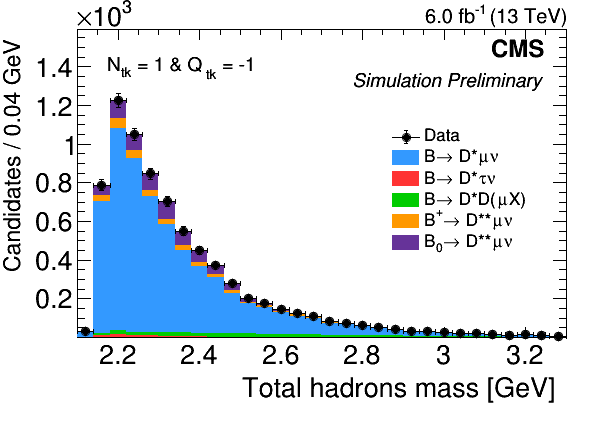

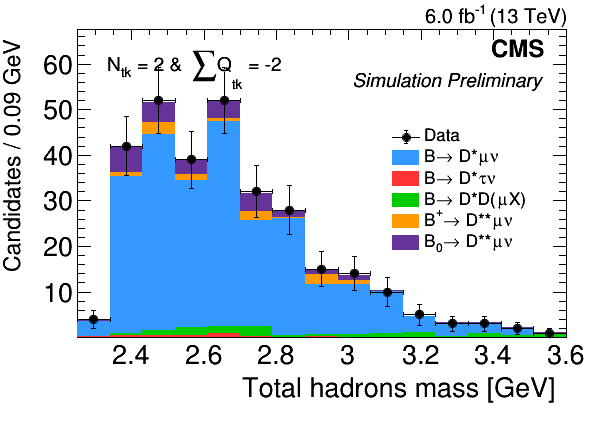

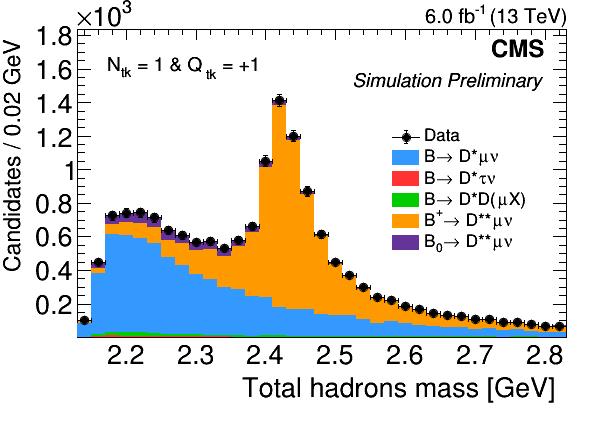

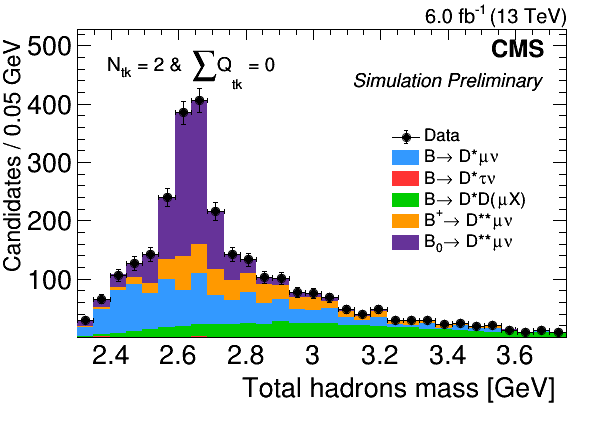

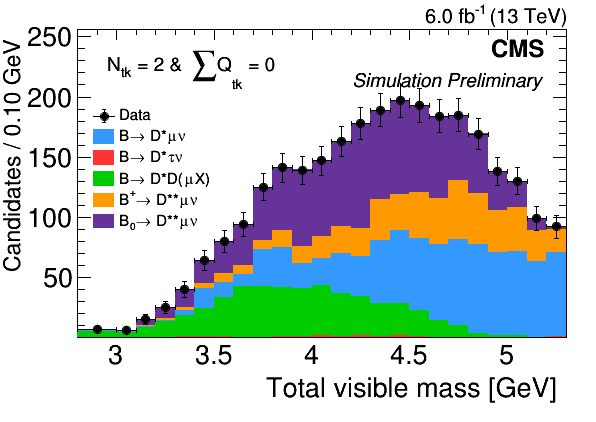

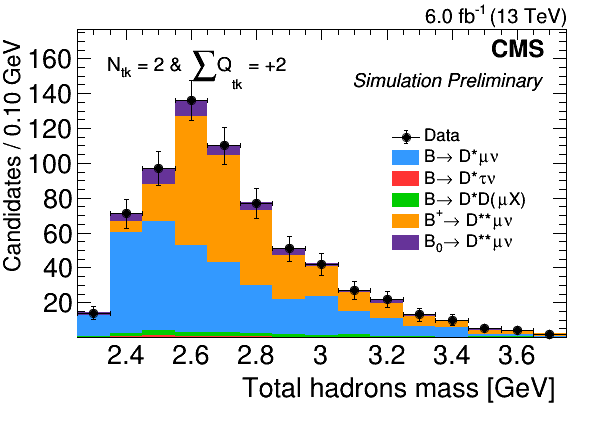

In [24]:
cSidePre = {}
for k in np.sort(sideVar.keys()):
    legLoc = [0.65, 0.4, 0.9, 0.7]
    if 'MassVis' in sideVar[k]:
        legLoc = [0.15, 0.45, 0.35, 0.75]
    cSidePre[k] = plot_SingleCategory(CMS_lumi, histo[k], scale_dic=scale_dic,
                                      xtitle=sideXtitle[k], addText=sideAddtext[k], 
                                      tag=k, legLoc=legLoc)

In [25]:
histo_file_dir = '../data/_root/histos4combine/'
if not os.path.isdir(histo_file_dir):
    os.makedirs(histo_file_dir)
histo_file_loc = {}
for cat_name, h_dic in histo.iteritems():
    histo_file_loc[cat_name] = histo_file_dir+'{}_{}.root'.format(card_name, cat_name)
    tf = rt.TFile(histo_file_loc[cat_name], 'recreate')
    for v in h_dic.values():
        v.Write()
    tf.Close()
    
del dSet, dSetTkSide

# Write the card

In [26]:
sig_processes = ['tau', 'mu']
bkg_processes = ['DstmD0', 'DstmDp', 'DstmDsp', 
                 'BpDstmHc', 'BmDstmHc', 'antiB0DstmHc',
                 'DstPip', 'DstPipPi0', 
                 'DstPi0', 'DstPipPim', 'DstPi0Pi0']
processes = sig_processes + bkg_processes
nProc = len(processes)
categories = np.sort([k for k in histo.keys()])
nCat = len(categories)

In [27]:
# number of different categories
card = 'imax *\n'
# number of processes minus one
card += 'jmax {}\n'.format(len(processes)-1)
# number of nuissance parameters
card += 'kmax *\n'
card += '--------------------------------------------------------------\n'

In [28]:
# shape file location
for k in categories:
    card += 'shapes * {} {} $PROCESS $PROCESS__$SYSTEMATIC\n'.format(k, histo_file_loc[k])
card += '--------------------------------------------------------------\n'

### Number of events

In [29]:
# number of events observed
card += 'bin ' + ' '.join(categories) + '\n'
obs = map(lambda k: '{:.0f}'.format(histo[k]['data'].Integral()), categories)
obs = ' '.join(obs)
card += 'observation ' + obs + '\n'
card += '--------------------------------------------------------------\n'

In [30]:
# MC expected events
aux_bin = ''
aux_proc_name = ''
aux_proc_id = ''
aux_proc_rate = ''
for c, p in itertools.product(categories, processes):
    aux_bin += ' '+c
    aux_proc_name += ' '+p
    aux_proc_id += ' '+str(np.argmax(np.array(processes) == p))
    aux_proc_rate += ' {:.2f}'.format(histo[c][p].Integral())
    
card += 'bin' + aux_bin + '\n'
card += 'process' + aux_proc_name + '\n'
# Zero or negative for sig and positive for bkg
card += 'process' + aux_proc_id + '\n'
# Expected rate
card += 'rate' + aux_proc_rate + '\n'
card += '--------------------------------------------------------------\n'

## Systematic uncertainties

### Scale systematics

In [31]:
#pp -> bb cros-section * luminosity
card += 'xsecpp2bbXlumi lnN' + ' 1.9'*nProc*nCat + '\n'

In [32]:
#Hadronization fraction of B0
aux = ''
for n in processes:
    if n in ['tau', 'mu', 'DstmD0', 'DstmDp', 'DstmDsp', 'DstPi0', 'DstPipPim', 'DstPi0Pi0', 'antiB0DstmHc']: 
        aux += ' 1.7'
    else: aux += ' -'
card += 'b2B0Had lnN' + aux*nCat + '\n'

In [33]:
#Hadronization fraction of B+
aux = ''
for n in processes:
    if n in ['DstPip', 'DstPipPi0', 'BpDstmHc', 'BmDstmHc']: aux += ' 1.7'
    else: aux += ' -'
card += 'b2BpHad lnN' + aux*nCat + '\n'

In [34]:
# Branching ration uncertainty
for n in processes:
    if n in ['tau', 'DstPip', 'DstPi0', 'DstPipPim', 'DstPipPi0', 'DstPi0Pi0', 'BmDstmHc']: continue
    val = ' {:.2f}'.format(1+decayBR[n][1]/decayBR[n][0])
    aux = ''
    for nn in processes:
        if nn == n: aux += val
        else: aux += ' -'
    card += n + 'Br lnN' + aux*nCat + '\n'

In [35]:
# Branching ration uncertainty with isospin symmetry constraint
val = ' {:.2f}'.format(1+decayBR['DstPip'][1]/decayBR['DstPip'][0]) #DstPi0 has no info
aux = ''
for n in processes:
    if n in ['DstPip', 'DstPi0']: aux += val
    else: aux += ' -'
card += 'DstPiBr lnN' + aux*nCat + '\n'

val = ' {:.2f}'.format(1+decayBR['DstPipPim'][1]/decayBR['DstPipPim'][0]) #DstPipPim is the only one meaasured
aux = ''
for n in processes:
    if n in ['DstPipPim', 'DstPipPi0', 'DstPi0Pi0']: aux += val
    else: aux += ' -'
card += 'DstPiPiBr lnN' + aux*nCat + '\n'

In [36]:
card += '--------------------------------------------------------------\n'

### Rate parameters

In [37]:
# card += 'pAddTk param 1.0 0.15\n'

In [38]:
# linear = []
# quadratic = []

# for procAux in ['tau', 'mu', 'DstPi0', 'DstPi0Pi0']: 
#     linear.append(['AddTk_p_mHad', procAux])
    
# for procAux in ['tau', 'mu', 'DstPi0', 'DstPi0Pi0', 'DstPip', 'DstPipPi0']: 
#     linear.append(['AddTk_m_mHad', procAux])
    
# for procAux in ['DstPip', 'DstPipPi0', 'DstPipPim', 'DstmD0', 'DstmDp', 'DstmDsp']:
#     linear.append(['AddTk_pp_mHad', procAux])
# for procAux in ['tau', 'mu', 'DstPi0', 'DstPi0Pi0']:
#     quadratic.append(['AddTk_pp_mHad', procAux])
    

# for procAux in ['DstPip', 'DstPipPi0']:
#     linear.append(['AddTk_pm_mHad', procAux])
#     linear.append(['AddTk_pm_mVis', procAux])
# for procAux in ['tau', 'mu', 'DstPi0', 'DstPi0Pi0']:
#     quadratic.append(['AddTk_pm_mHad', procAux])
#     quadratic.append(['AddTk_pm_mVis', procAux])
    
# for procAux in ['DstPipPim', 'DstmD0', 'DstmDp', 'DstmDsp']:
#     linear.append(['AddTk_mm_mHad', procAux])
# for procAux in ['tau', 'mu', 'DstPi0', 'DstPi0Pi0', 'DstPip', 'DstPipPi0']:
#     quadratic.append(['AddTk_mm_mHad', procAux])
    
# for binAux, procAux in linear:
#     card += 'pAddTk rateParam {} {} 1\n'.format(binAux, procAux)
# for binAux, procAux in quadratic:
#     card += 'pAddTk2 rateParam {} {} @0*@0 pAddTk\n'.format(binAux, procAux)

In [39]:
# card += '--------------------------------------------------------------\n'

### Shape Systematics

In [40]:
card += 'trgSF shape' + ' 1.'*nProc*nCat + '\n'

In [41]:
card += 'muonIdSF shape' + ' 1.'*nProc*nCat + '\n'

In [42]:
aux = ''
for cat in categories:
    if cat.startswith('AddTk_'):
        aux += ' 1.'*nProc
    else: aux += ' -'*nProc
card += 'tkPVfrac shape' + aux + '\n'

In [43]:
# B0 pT spectrum
aux = ''
for p in processes:
    if p in ['tau', 'mu', 'DstmD0', 'DstmDp', 'DstmDsp', 'DstPi0', 'DstPipPim', 'DstPi0Pi0']:
        aux += ' 1.'
    else:
        aux += ' -'
card += 'B0pT shape' + aux*nCat + '\n'

In [44]:
# Form Factors from Hammer
for n_pFF in ['R0', 'R1', 'R2', 'RhoSq']:
    aux = ''
    for p in processes:
        if p in ['tau', 'mu']:
            aux += ' 1.'
        else:
            aux += ' -'
    card += 'B2DstCLN{} shape'.format(n_pFF) + aux*nCat + '\n'

In [45]:
# Dstst mix composition
aux = ''
for p in processes:
    if p == 'DstPip': aux += ' 1.'
    else: aux += ' -'
card += 'fDststWide shape' + aux*nCat + '\n'

In [46]:
# Hc mix composition
aux = ''
for p in processes:
    if p == 'DstmD0': aux += ' 1.'
    else: aux += ' -'
card += 'BrB02DstD0Kp shape' + aux*nCat + '\n'
card += 'BrB02DstD0Kstp shape' + aux*nCat + '\n'
card += 'BrB02DstDst0Kp shape' + aux*nCat + '\n'
card += 'BrB02DstDst0Kstp shape' + aux*nCat + '\n'

aux = ''
for p in processes:
    if p == 'DstmDp': aux += ' 1.'
    else: aux += ' -'
card += 'BrB02DstDpK0 shape' + aux*nCat + '\n'
card += 'BrB02DstDpKst0 shape' + aux*nCat + '\n'

aux = ''
for p in processes:
    if p == 'DstmDp' or p == 'DstmD0': aux += ' 1.'
    else: aux += ' -'
card += 'BrB02DstDstpK0 shape' + aux*nCat + '\n'
card += 'BrB02DstDstpKst0 shape' + aux*nCat + '\n'

aux = ''
for p in processes:
    if p == 'DstmDsp': aux += ' 1.'
    else: aux += ' -'
card += 'BrB02DstDs shape' + aux*nCat + '\n'
card += 'BrB02DstDsst shape' + aux*nCat + '\n'
card += 'BrB02DstDs0st shape' + aux*nCat + '\n'

### MC statistic systematics

In [47]:
card += '* autoMCStats 10 1 1\n'
card += '--------------------------------------------------------------\n'

### Defining groups of systematics

In [48]:
# autoMCStats group = defined by default when using autoMCStats
aux_FF = ' '.join(['B2DstCLN'+n for n in ['R0', 'R1', 'R2', 'RhoSq']])
card += 'B2DstFF group = ' + aux_FF + '\n'

# card += 'normMC group = xsecpp2bbXlumi b2B0Had b2BpHad\n'

# card += 'knownBr group = ' + ' '.join([n+'Br' for n in processes if not n == 'tau']) + '\n'

card += 'allShape group = trgSF muonIdSF B0pT ' + aux_FF + '\n'

## Create output

In [49]:
print card

imax *
jmax 12
kmax *
--------------------------------------------------------------
shapes * AddTk_m_mHad ../data/_root/histos4combine/v8_low_AddTk_m_mHad.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * AddTk_mm_mHad ../data/_root/histos4combine/v8_low_AddTk_mm_mHad.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * AddTk_p_mHad ../data/_root/histos4combine/v8_low_AddTk_p_mHad.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * AddTk_pm_mHad ../data/_root/histos4combine/v8_low_AddTk_pm_mHad.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * AddTk_pm_mVis ../data/_root/histos4combine/v8_low_AddTk_pm_mVis.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * AddTk_pp_mHad ../data/_root/histos4combine/v8_low_AddTk_pp_mHad.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * Est_mu_q2bin0 ../data/_root/histos4combine/v8_low_Est_mu_q2bin0.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * Est_mu_q2bin1 ../data/_root/histos4combine/v8_low_Est_mu_q2bin1.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * Est_mu_q2bin2 ../data/_root/histos4com

In [50]:
card_location = 'cards/{}.txt'.format(card_name)
fc = open(card_location, 'w')
fc.write(card)
fc.close()

In [51]:
outdir = 'results/' + card_name
if os.path.isdir(outdir):
    os.system('rm -rf ' + outdir)
os.system('mkdir -p ' + outdir + '/fig');

# Run Combine

## Create the workspace

In [52]:
cmd = 'text2workspace.py ' + card_location 
cmd += ' -o ' + card_location.replace('.txt', '.root')
cmd += ' --no-b-only'
cmd += ' --verbose 1'
# cmd += ' --no-wrappers'
out = os.system(cmd)
if out: raise

Channel AddTk_m_mHad will use autoMCStats with settings: event-threshold=10, include-signal=1, hist-mode=1
Analysing bin errors for: prop_binAddTk_m_mHad
Poisson cut-off: 10
Bin        Contents        Error           Notes                         
0          32.044502       3.760907        total sum                     
0          73.000000       8.544004        Unweighted events, alpha=0.438966
  => Total parameter prop_binAddTk_m_mHad_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          812.117928      18.623207       total sum                     
1          1902.000000     43.611925       Unweighted events, alpha=0.426981
  => Total parameter prop_binAddTk_m_mHad_bin1[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
2          1260.263942     23.188095       total sum                     
2          2954.000000     54.350713       Unweighted events, alpha=0.42

Creating pdfs for individual modes (14): .    1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   11.   12.   13.   14done.
Importing combined pdf model_s


## Run the Maximum Likelyhood fit

In [53]:
seedMLf = '6741'

In [54]:
cmd = 'combine -M FitDiagnostics'
cmd += ' --robustFit 1 --robustHesse 1 --cminDefaultMinimizerStrategy 0 --X-rtd MINIMIZER_analytic'
cmd += ' --skipBOnlyFit'
cmd += ' --seed ' + seedMLf
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --setParameters r={:.2f}'.format(SM_RDst)
cmd += ' --setParameterRanges r=0.01,5'
cmd += ' -n {}'.format(card_name)
cmd += ' --out ' + outdir
cmd += ' --saveShapes --saveWithUncertainties --saveNormalizations'
cmd += ' --plots'
cmd += ' --verbose 1'

print cmd
status, output = commands.getstatusoutput(cmd)
for line in output.split('\n'):
        if 'ERROR' in line: print line.replace('ERROR', '\033[1m\x1b[31mError\x1b[0m')
os.system('mv combine_logger.out ' + outdir + '/combine_logger_FitDiagnostics.out')
os.system('mv ./higgsCombine{}.FitDiagnostics.mH120.{}.root '.format(card_name, seedMLf) + outdir + '/');

combine -M FitDiagnostics --robustFit 1 --robustHesse 1 --cminDefaultMinimizerStrategy 0 --X-rtd MINIMIZER_analytic --skipBOnlyFit --seed 6741 -d cards/v8_low.root -D data_obs --setParameters r=0.33 --setParameterRanges r=0.01,5 -n v8_low --out results/v8_low --saveShapes --saveWithUncertainties --saveNormalizations --plots --verbose 1
Messages of type Error : 0


In [55]:
f = ur.open(glob(outdir + '/higgsCombine{}.FitDiagnostics.mH120.{}.root'.format(card_name, seedMLf))[0])
c, d, u, _ = f['limit']['limit'].array()
print 'R(D*) = {:.3f} +{:.3f}/-{:.3f} [{:.1f} %]'.format(c, u-c, c-d, 100*(u-d)*0.5/c)
rDst_postFitRegion = [max(0.01,c - 5*(c-d)), min(c + 5*(u-c), 0.9)]

R(D*) = 0.330 +4.670/-0.320 [756.0 %]


In [56]:
# Get post-fit shapes
fFitDiagnostics = rt.TFile.Open(outdir + '/fitDiagnostics{}.root'.format(card_name), 'READ')
fd = fFitDiagnostics.shapes_fit_s

histo_postfit = {}
for cat, h_dic in histo.iteritems():
    histo_postfit[cat] = {}
    for n, h in h_dic.iteritems():
        if '__' in n:
            continue
        h_post = h.Clone(h.GetName() + '_postfit')
        if 'data' in n:
            h_fit = fd.Get(cat+'/total')
            h_data = h.Clone(h.GetName() + '_data')
            for i in range(1, h_post.GetNbinsX()+1):
                h_post.SetBinContent(i, h_fit.GetBinContent(i))
                h_post.SetBinError(i, h_fit.GetBinError(i))     
            
            histo_postfit[cat]['total'] = h_post
            histo_postfit[cat][n] = h_data
        else:
            h_fit = fd.Get(cat+'/'+n)
            if not h_fit: 
                print n+' missing from '+cat
                continue
            for i in range(1, h_post.GetNbinsX()+1):
                h_post.SetBinContent(i, h_fit.GetBinContent(i))
                h_post.SetBinError(i, h_fit.GetBinError(i)) 

            histo_postfit[cat][n] = h_post

BmDstmHc missing from AddTk_pp_mHad


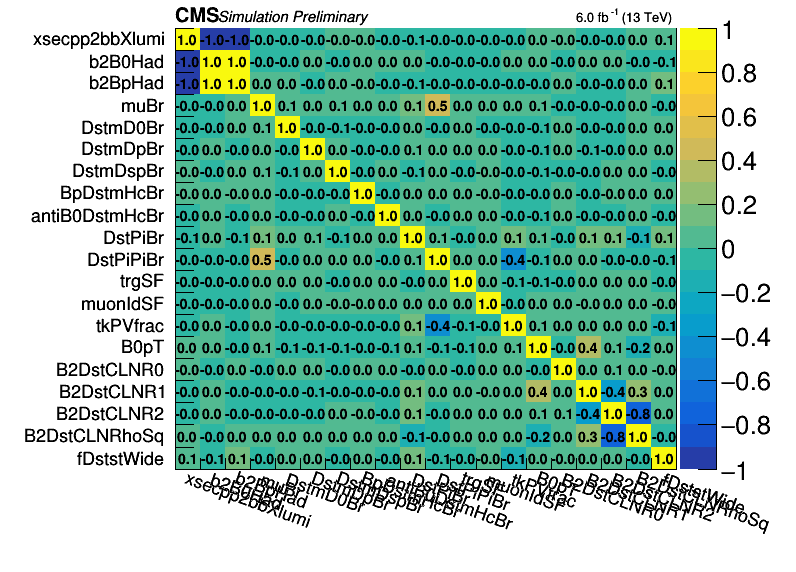

In [57]:
h2 = fFitDiagnostics.Get('covariance_fit_s')
rt.gStyle.SetPaintTextFormat('.1f')

N = h2.GetNbinsX()
n=20

h2.GetXaxis().SetRange(1, n)
h2.GetYaxis().SetRangeUser(N-n, N)
h2.SetMarkerSize(1.3)
CC = drawOnCMSCanvas(CMS_lumi, [h2, h2], ['colz', 'text same'], tag='tl', mL=0.22, mR=0.15, mB=0.18)
CC.SaveAs(outdir+'/fig/covariance_zoom.png')

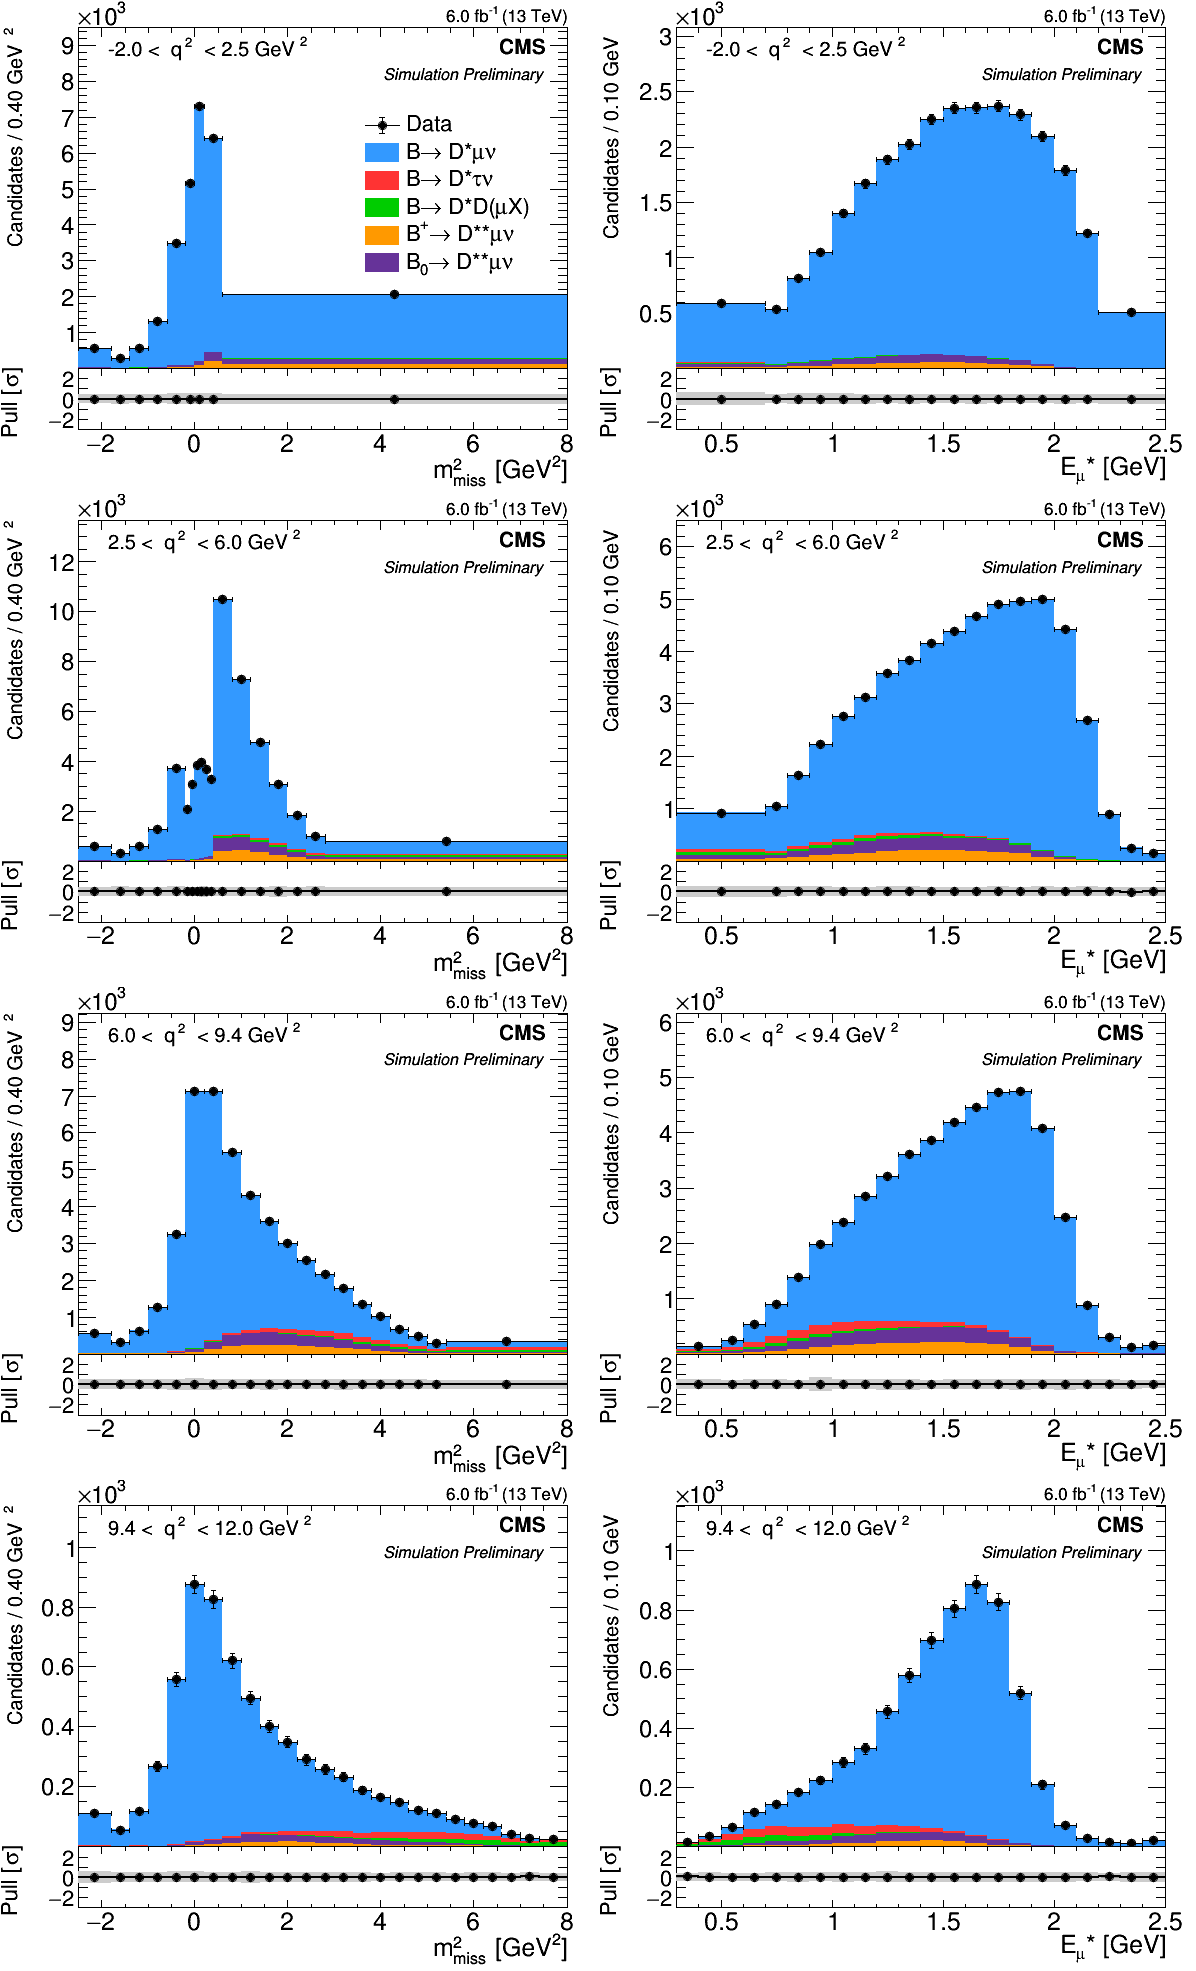

In [58]:
cSigPost = plot_gridVarQ2(CMS_lumi, binning, histo_postfit, draw_pulls=True, pulls_ylim=[-5, 5])
cSigPost.SaveAs(outdir+'/fig/signalRegion_postfit.png')

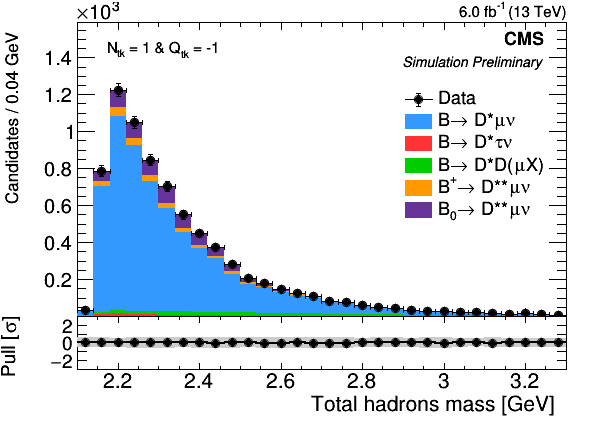

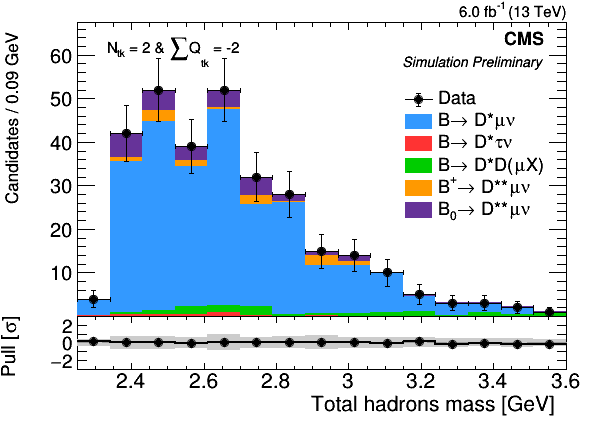

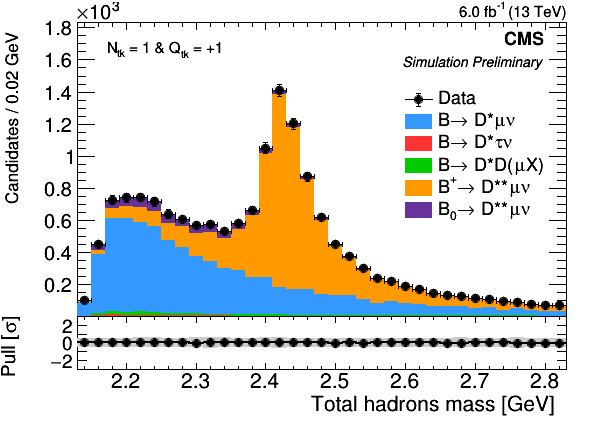

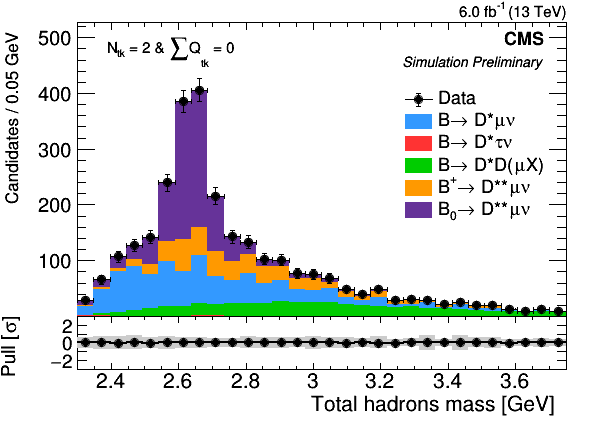

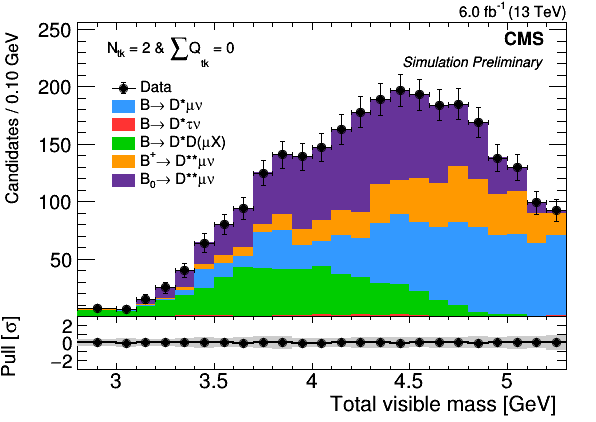

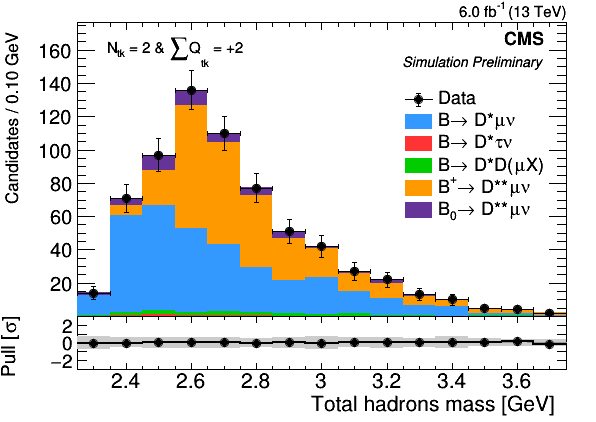

In [59]:
cSidePost = {}
for k in np.sort(sideVar.keys()):
    legLoc = [0.67, 0.3, 0.93, 0.72]
    if 'MassVis' in sideVar[k]:
        legLoc = [0.18, 0.4, 0.4, 0.75]
    cSidePost[k] = plot_SingleCategory(CMS_lumi, histo_postfit[k], 
                                       xtitle=sideXtitle[k], addText=sideAddtext[k], 
                                       tag=k, legLoc=legLoc,
                                       draw_pulls=True
                                      )
    cSidePost[k].SaveAs(outdir+'/fig/'+k+'_postfit.png')

In [60]:
cmd = 'python diffNuisances.py '.format(os.environ['CMSSW_BASE'])
cmd += outdir + '/fitDiagnostics{}.root'.format(card_name)
cmd += ' --skipFitB'
# cmd += ' --all'
cmd += ' --abs'
cmd += ' -g {}/nuisance_difference.root'.format(outdir)
print cmd
status, output = commands.getstatusoutput(cmd)
dumpDiffNuisances(output, outdir)

python diffNuisances.py results/v8_low/fitDiagnosticsv8_low.root --skipFitB --abs -g results/v8_low/nuisance_difference.root
+------------------------------------+------------------------+---------------------------------+
|             Parameter              |        pre-fit         |             post-fit            |
+------------------------------------+------------------------+---------------------------------+
|    prop_binAddTk_pp_mHad_bin13     | 0.000000 +/- 1.000000  | +0.10 +/- 0.89 (+0.10sig, 0.89) |
| prop_binAddTk_pp_mHad_bin14_DstPip |  7.000000 +/- 2.634286 | +6.77 +/- 2.37 (-0.09sig, 0.90) |
|   prop_binAddTk_mm_mHad_bin11_mu   |  6.000000 +/- 2.438589 | +5.79 +/- 2.04 (-0.09sig, 0.84) |
|   prop_binAddTk_mm_mHad_bin13_mu   |  5.000000 +/- 2.225802 | +4.83 +/- 1.97 (-0.08sig, 0.88) |
|   prop_binAddTk_mm_mHad_bin10_mu   |  6.000000 +/- 2.438589 | +6.16 +/- 2.14 (+0.07sig, 0.88) |
|     prop_binAddTk_mm_mHad_bin0     |  0.000000 +/- 1.000000 | +0.06 +/- 0.88 (+0.06sig, 0

## Run likelyhood scan

combine -M MultiDimFit --algo grid --points=100 --robustFit 1 -d cards/v8_low.root -D data_obs --X-rtd MINIMIZER_analytic --rMin=0.0100 --rMax=0.9000 -n v8_low_nominal --verbose -1
----------------------------------
R(D*) = 0.330 +0.038/-0.038 [11.5 %]
Sigma = 0.038
----------------------------------



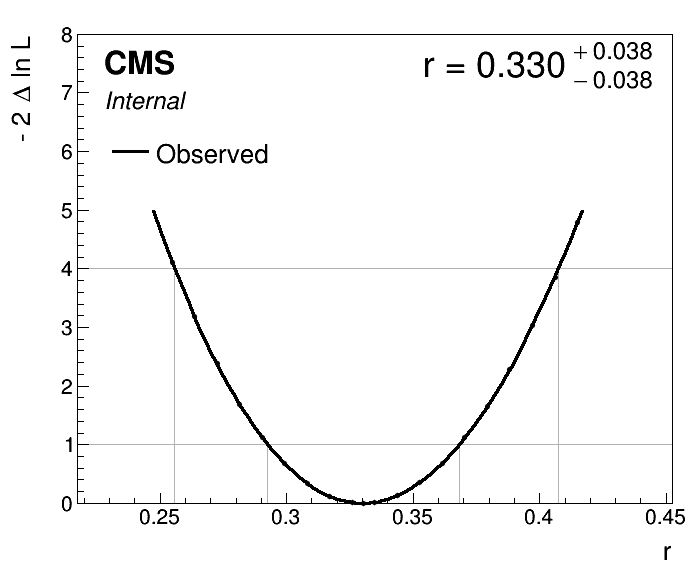

 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
>> Enabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Disabling analytic minimisation of bin-wise statistical uncertainty parameters
Done in 1.45 min (cpu), 1.45 min (real)
--------------------------------------
scan
--------------------------------------
[{'lo': 0.292588270763167, 'hi': 0.3682830896198907, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.2557961424629384, 'hi': 0.4074525071358878, 'valid_hi': True, 'valid_lo': True}]


Info in <TCanvas::Print>: pdf file ./scan.pdf has been created
Info in <TCanvas::Print>: png file ./scan.png has been created


In [61]:
cmd = 'combine'
cmd += ' -M MultiDimFit'
cmd += ' --algo grid --points=100'
cmd += ' --robustFit 1'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --rMin={:.4f} --rMax={:.4f}'.format(*rDst_postFitRegion)
cmd += ' -n {}_nominal'.format(card_name)
cmd += ' --verbose -1'
print cmd
os.system(cmd)
cmd = 'plot1DScan.py higgsCombine{}_nominal.MultiDimFit.mH120.root'.format(card_name)
cmd += '; mv scan.png scan_nominal.png'
os.system(cmd)
res_nominal = getUncertaintyFromLimitTree('higgsCombine{}_nominal.MultiDimFit.mH120.root'.format(card_name))
display(Image(filename='scan_nominal.png'))

### Uncertainy breakdown by group

In [62]:
cmd = 'combine -M MultiDimFit --algo none'
cmd += ' --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --setParameters r={:.2f}'.format(SM_RDst)
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' -n {}_bestfit'.format(card_name)
cmd += ' --saveWorkspace --verbose -1'
print cmd
os.system(cmd);

combine -M MultiDimFit --algo none --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic -d cards/v8_low.root -D data_obs --setParameters r=0.33 --setParameterRanges r=0.001,1 -n v8_low_bestfit --saveWorkspace --verbose -1
 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
   r :    +0.330
Done in 0.02 min (cpu), 0.02 min (real)


In [63]:
# Statistical uncertainty
cmd = 'combine -M MultiDimFit --algo grid --points=100'
cmd += ' --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' -d higgsCombine{}_bestfit.MultiDimFit.mH120.root'.format(card_name)
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --rMin={:.4f} --rMax={:.4f}'.format(*rDst_postFitRegion)
cmd += ' -n {}_stat'.format(card_name)
cmd += ' --snapshotName MultiDimFit'
cmd += ' --freezeNuisanceGroups=autoMCStats,allShape'
cmd += ' --verbose -1'
print cmd
os.system(cmd);

combine -M MultiDimFit --algo grid --points=100 --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic -d higgsCombinev8_low_bestfit.MultiDimFit.mH120.root -D data_obs --rMin=0.0100 --rMax=0.9000 -n v8_low_stat --snapshotName MultiDimFit --freezeNuisanceGroups=autoMCStats,allShape --verbose -1
 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
>> Disabling analytic minimisation of bin-wise statistical uncertainty parameters
Done in 0.37 min (cpu), 0.37 min (real)


In [64]:
# MC Statistics
cmd = 'combine -M MultiDimFit --algo grid --points=100'
cmd += ' --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' -d higgsCombine{}_bestfit.MultiDimFit.mH120.root'.format(card_name)
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --rMin={:.4f} --rMax={:.4f}'.format(*rDst_postFitRegion)
cmd += ' -n {}_MCstat'.format(card_name)
cmd += ' --snapshotName MultiDimFit'
cmd += ' --freezeNuisanceGroups=autoMCStats'
cmd += ' --verbose -1'
print cmd
os.system(cmd);

combine -M MultiDimFit --algo grid --points=100 --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic -d higgsCombinev8_low_bestfit.MultiDimFit.mH120.root -D data_obs --rMin=0.0100 --rMax=0.9000 -n v8_low_MCstat --snapshotName MultiDimFit --freezeNuisanceGroups=autoMCStats --verbose -1
 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
>> Disabling analytic minimisation of bin-wise statistical uncertainty parameters
Done in 0.63 min (cpu), 0.63 min (real)


plot1DScan.py higgsCombinev8_low_nominal.MultiDimFit.mH120.root --others "higgsCombinev8_low_MCstat.MultiDimFit.mH120.root:Freeze MC stat:4" "higgsCombinev8_low_stat.MultiDimFit.mH120.root:Freeze all:2" --breakdown MCstat,syst,stat; mv scan.png scan_MCstat.png


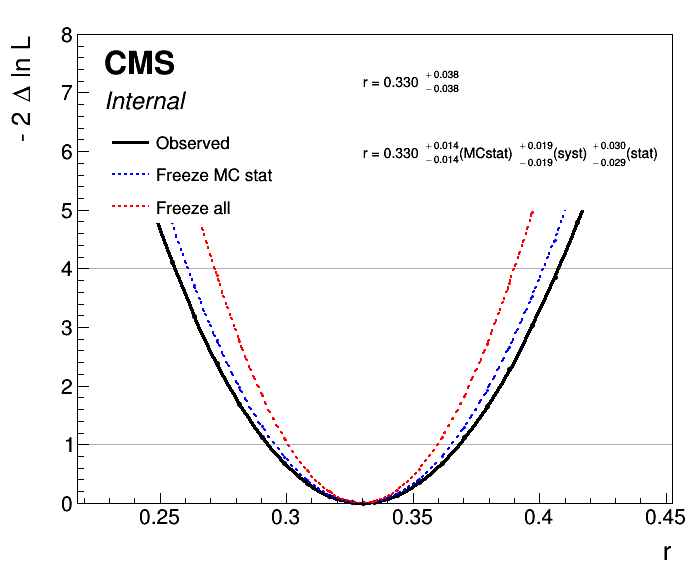

--------------------------------------
scan
--------------------------------------
[{'lo': 0.292588270763167, 'hi': 0.3682830896198907, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.2557961424629384, 'hi': 0.4074525071358878, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.2953252626981166, 'hi': 0.36545811880002704, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.26118765682553696, 'hi': 0.40167850610939454, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.3006861627540992, 'hi': 0.35985685770512676, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.27168884231587753, 'hi': 0.39019087738785624, 'valid_hi': True, 'valid_lo': True}]


Info in <TCanvas::Print>: pdf file ./scan.pdf has been created
Info in <TCanvas::Print>: png file ./scan.png has been created


In [65]:
cmd = 'plot1DScan.py higgsCombine{}_nominal.MultiDimFit.mH120.root'.format(card_name)
cmd += ' --others'
cmd += ' "higgsCombine{}_MCstat.MultiDimFit.mH120.root:Freeze MC stat:4"'.format(card_name)
cmd += ' "higgsCombine{}_stat.MultiDimFit.mH120.root:Freeze all:2"'.format(card_name)
cmd += ' --breakdown MCstat,syst,stat'
cmd += '; mv scan.png scan_MCstat.png'
print cmd
os.system(cmd)
display(Image(filename='scan_MCstat.png'))

In [66]:
os.system('mv higgsCombine*.root ' + outdir + '/')
os.system('mv scan* ' + outdir + '/')
os.system('mv combine_logger.out ' + outdir + '/');

In [67]:
if fastRun:
    raise

## Run the impact plots

Fit first the POI

In [68]:
os.mkdir(outdir+'/impactPlots')

In [69]:
cmd = 'cd {}/impactPlots;'.format(outdir)
cmd += ' combineTool.py -M Impacts --doInitialFit -m 120'
cmd += ' --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' -d ../../../' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --setParameters r={:.2f}'.format(SM_RDst)
cmd += ' --setParameterRanges r=0.01,1'
cmd += ' -n {}'.format(card_name)
cmd += ' --verbose -1'
os.system(cmd);

Have POIs: ['r']
 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
   r :    +0.330   -0.037/+0.038 (68%)
Done in 0.31 min (cpu), 0.31 min (real)
>> combine -M MultiDimFit -n _initialFit_v8_low --algo singles --redefineSignalPOIs r --robustFit 1 --X-rtd MINIMIZER_analytic -D data_obs --setParameterRanges r=0.01,1 --verbose -1 -m 120 -d ../../../cards/v8_low.root --setParameters r=0.33


 Perform a similar scan for each nuisance parameter

If running on Tier2 condor remmeber to add this line to CombineToolBase.py ln 11
``source /cvmfs/cms.cern.ch/cmsset_default.sh``

In [70]:
cmd = 'cd {}/impactPlots;'.format(outdir)
cmd += ' combineTool.py -M Impacts --doFits -m 120'
cmd += ' --robustFit 1 --X-rtd MINIMIZER_analytic'
# cmd += ' --parallel 20'
cmd += ' --parallel 100 --job-mode condor --task-name combineImpacts'
cmd += ' --sub-opts "{}"'.format(stringJubCustomizationCaltechT2.replace('"', '\\\"').replace('$', '\$'))
cmd += ' -d ../../../' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' -n {}'.format(card_name)
cmd += ' --verbose -1'
print cmd
os.system(cmd);

cd results/v8_low/impactPlots; combineTool.py -M Impacts --doFits -m 120 --robustFit 1 --X-rtd MINIMIZER_analytic --parallel 100 --job-mode condor --task-name combineImpacts --sub-opts "
+RunAsOwner = True
+InteractiveUser = True
+SingularityImage = \"/cvmfs/singularity.opensciencegrid.org/cmssw/cms:rhel7-m20200605\"
+SingularityBindCVMFS = True
+MaxRuntime = 3600
RequestDisk = 200000
RequestMemory = 2500
RequestCpus = 1
x509userproxy = \$ENV(X509_USER_PROXY)
" -d ../../../cards/v8_low.root -D data_obs -n v8_low --verbose -1
Submitting job(s).....................................................................................................................................................................................................................................................................................................................................................................................
373 job(s) submitted to cluster 1942.
Have POIs: ['r']
Have parameters: 373
>>

Collect the results

In [71]:
status, output = commands.getstatusoutput('condor_q')
while 'combineImpacts' in output:
    time.sleep(20)
    status, output = commands.getstatusoutput('condor_q')
    for l in output.split('\n'):
        if 'combineImpacts' in l: 
            print l
            sys.stdout.flush()
cmd = 'cd {}/impactPlots;'.format(outdir)
cmd += ' combineTool.py -M Impacts -o impacts.json -m 120'
cmd += ' -d ../../../' + card_location.replace('.txt', '.root')
cmd += ' -n {}'.format(card_name)
print cmd
os.system(cmd);

ocerri combineImpacts   7/6  23:06      _      _    373    373 1942.0-372
ocerri combineImpacts   7/6  23:06      _      5    368    373 1942.0-372
ocerri combineImpacts   7/6  23:06      _      8    365    373 1942.0-372
ocerri combineImpacts   7/6  23:06      _      9    364    373 1942.0-372
ocerri combineImpacts   7/6  23:06      _     19    354    373 1942.0-372
ocerri combineImpacts   7/6  23:06      1     22    350    373 1942.0-372
ocerri combineImpacts   7/6  23:06      2     25    346    373 1942.0-372
ocerri combineImpacts   7/6  23:06      6     28    339    373 1942.2-372
ocerri combineImpacts   7/6  23:06      9     31    333    373 1942.2-372
ocerri combineImpacts   7/6  23:06     17     34    322    373 1942.6-372
ocerri combineImpacts   7/6  23:06     22     34    317    373 1942.6-372
ocerri combineImpacts   7/6  23:06     31     36    306    373 1942.6-372
ocerri combineImpacts   7/6  23:06     38     40    295    373 1942.23-372
ocerri combineImpacts   7/6  23:06   

In [72]:
rename = {
'r': 'R(D*)',
'B0pT': 'B_{0} p_{T} spectrum',
'B2DstCLNR0':'R_{0} (CLN B#rightarrow D*#ell#nu)',
'B2DstCLNR1':'R_{1} (CLN B#rightarrow D*)',
'B2DstCLNR2':'R_{2} (CLN B#rightarrow D*)',
'B2DstCLNRhoSq':'#rho^{2} (CLN B#rightarrow D*)',
'trgSF': 'Trigger scale factor',
'xsecpp2bbXlumi': 'Luminosity*#sigma_{pp#rightarrowbb}',
    
}

procName_dic = {
'mu'        : 'B_{0}#rightarrow D*#mu#nu',
'tau'       : 'B_{0}#rightarrow D*#tau#nu',
'DstmD0'    : 'B^{+}#rightarrow D*D_{0}(#muY) + X',
'DstmDp'    : 'B^{+}#rightarrow D*D^{+}(#muY) + X',
'DstmDsp'   : 'B^{+}#rightarrow D*D_{s}^{+}(#muX)',
'DstPip'    : 'B^{+}#rightarrow D*#pi^{+}#mu#nu',
'DstPipPi0' : 'B^{+}#rightarrow D*#pi^{+}#pi^{0}#mu#nu',
'DstPi0'    : 'B_{0}#rightarrow D*#pi^{0}#mu#nu',
'DstPipPim' : 'B_{0}#rightarrow D*#pi^{+}#pi^{-}#mu#nu',
'DstPi0Pi0' : 'B_{0}#rightarrow D*#pi^{0}#pi^{0}#mu#nu',
'BpDstmHc'  : 'B^{+}#rightarrow D*D(#muX)',
'BmDstmHc'  : 'B^{-}#rightarrow D*D(#muX)',
'antiB0DstmHc'  : '#bar{B}_{0}#rightarrow D*D(#muX)',
}

for n in processes:
    rename[n+'Br'] = 'Branching fraction ' + procName_dic[n]

d = json.load(open(outdir+'/impactPlots/impacts.json', 'r'))
for par in d['params']:
    name = str(par['name'])
    if not name.startswith('prop_bin'): continue
    label = name.replace('prop_bin', 'MC stat. ')
    label = label.replace('M2_miss_', 'M^{2}_{miss} ')
    label = label.replace('Est_mu_', 'E*_{#mu} ')
    label = label.replace('q2bin', '[b_{q^{2}}=')
    label = label.replace('_bin', '] ')
    rename[name] = label + 10*' '
    
json.dump(rename, open(outdir+'/impactPlots/rename.json', 'w'))

cmd = 'cd {};'.format(outdir)
cmd += 'plotImpacts.py -i impactPlots/impacts.json -o impacts -t impactPlots/rename.json'
os.system(cmd)
IFrame(outdir+'/impacts.pdf', width=900, height=600)

>> Doing page 0, have 30 parameters
>> Doing page 1, have 30 parameters
>> Doing page 2, have 30 parameters
>> Doing page 3, have 30 parameters
>> Doing page 4, have 30 parameters
>> Doing page 5, have 30 parameters
>> Doing page 6, have 30 parameters
>> Doing page 7, have 30 parameters
>> Doing page 8, have 30 parameters
>> Doing page 9, have 30 parameters
>> Doing page 10, have 30 parameters
>> Doing page 11, have 30 parameters
>> Doing page 12, have 13 parameters


Info in <TCanvas::Print>: pdf file ./impacts.pdf has been created using the current canvas
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: impacts
Info in <TCanvas::Print>: Current canvas added to pdf file ./impacts.pdf
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: impacts
Info in <TCanvas::Print>: Current canvas added to pdf file ./impacts.pdf
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: impacts
Info in <TCanvas::Print>: Current canvas added to pdf file ./impacts.pdf
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: impacts
Info in <TCanvas::Print>: Current canvas added to pdf file ./impacts.pdf
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: impacts
Info in <TCanvas::Print>: Current canvas added to pdf file ./impacts.pdf
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: impacts
Info in <TCanvas::Print>: Current canvas added to pdf file ./imp

## Run the Goodness of fit test

Run the observed test stat value

In [73]:
cmd = 'combine -M GoodnessOfFit --toysFrequentist --algo=saturated'
cmd += ' --X-rtd MINIMIZER_analytic --cminDefaultMinimizerStrategy 0'
cmd += ' -d results/{cn}/higgsCombine{cn}_bestfit.MultiDimFit.mH120.root'.format(cn=card_name)
cmd += ' --snapshotName MultiDimFit --bypassFrequentistFit'
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' -n Obs'                                    # Just the output name
cmd += ' -t 0'                                      # Don't run toys
cmd += ' -s 1'                                      # Random seed
cmd += ' --setParameters r={:.2f}'.format(SM_RDst)
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' --plots --verbose -1'
print cmd
os.system(cmd)

combine -M GoodnessOfFit --toysFrequentist --algo=saturated --X-rtd MINIMIZER_analytic --cminDefaultMinimizerStrategy 0 -d results/v8_low/higgsCombinev8_low_bestfit.MultiDimFit.mH120.root --snapshotName MultiDimFit --bypassFrequentistFit -D data_obs -n Obs -t 0 -s 1 --setParameters r=0.33 --setParameterRanges r=0.001,1 --plots --verbose -1


0

 <<< Combine >>> 
Will use saturated models to compute goodness of fit for a binned likelihood
>>> method used is GoodnessOfFit
>>> random number generator seed is 1
Set Range of Parameter r To : (0.001,1)
Set Default Value of Parameter r To : 0.33
>> Enabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Disabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Enabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Disabling analytic minimisation of bin-wise statistical uncertainty parameters

 --- GoodnessOfFit --- 
Best fit test statistic: 0.448049
Done in 0.01 min (cpu), 0.01 min (real)


Missing background ModelConfig 'ModelConfig_bonly' in workspace 'w' in file /storage/user/ocerri/BPhysics/Combine/results/v8_low/higgsCombinev8_low_bestfit.MultiDimFit.mH120.root
Will make one from the signal ModelConfig 'ModelConfig' setting signal strenth 'r' to zero
RooSimultaneousOpt: number of channel masks must equal number of channels


Run the test stat toy distribution

In [74]:
cmd = 'combine -M GoodnessOfFit --toysFrequentist --algo=saturated'
cmd += ' --X-rtd MINIMIZER_analytic --cminDefaultMinimizerStrategy 0'
cmd += ' -d results/{cn}/higgsCombine{cn}_bestfit.MultiDimFit.mH120.root'.format(cn=card_name)
cmd += ' --snapshotName MultiDimFit --bypassFrequentistFit'
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' -n Toys'                                   # Just the output name
cmd += ' -t 30'                                     # Number of toys to run
cmd += ' -s -1'                                     # Random seed
cmd += ' --setParameters r={:.2f}'.format(SM_RDst)
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' --plots --verbose -1'
cmdToys = cmd
print cmdToys
# os.system(cmdToys)

combine -M GoodnessOfFit --toysFrequentist --algo=saturated --X-rtd MINIMIZER_analytic --cminDefaultMinimizerStrategy 0 -d results/v8_low/higgsCombinev8_low_bestfit.MultiDimFit.mH120.root --snapshotName MultiDimFit --bypassFrequentistFit -D data_obs -n Toys -t 30 -s -1 --setParameters r=0.33 --setParameterRanges r=0.001,1 --plots --verbose -1


In [75]:
from multiprocessing import Pool

def runCommand(cmd):
    os.system(cmd)

Nrep = 15
p = Pool(min(20,Nrep))
outputs = p.map(runCommand, Nrep*[cmdToys])

 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
Will use saturated models to compute goodness of fit for a binned likelihood
>>> method used is GoodnessOfFit
Will use saturated models to compute goodness of fit for a binned likelihood
Will use saturated models to compute goodness of fit for a binned likelihood
Will use saturated models to compute goodness of fit for a binned likelihood
Will use saturated models to compute goodness of fit for a binned likelihood
>>> method used is GoodnessOfFit
>>> method used is GoodnessOfFit
Will use saturated models to compute goodness of fit for a binned likelihood
Will use saturated models to compute goodness of fit for a binned likelihood
>>> method used is GoodnessOfFit
>>> method used is GoodnessOfFit
>>> method used is Goodnes

Missing background ModelConfig 'ModelConfig_bonly' in workspace 'w' in file /storage/user/ocerri/BPhysics/Combine/results/v8_low/higgsCombinev8_low_bestfit.MultiDimFit.mH120.root
Will make one from the signal ModelConfig 'ModelConfig' setting signal strenth 'r' to zero
Missing background ModelConfig 'ModelConfig_bonly' in workspace 'w' in file /storage/user/ocerri/BPhysics/Combine/results/v8_low/higgsCombinev8_low_bestfit.MultiDimFit.mH120.root
Missing background ModelConfig 'ModelConfig_bonly' in workspace 'w' in file /storage/user/ocerri/BPhysics/Combine/results/v8_low/higgsCombinev8_low_bestfit.MultiDimFit.mH120.root
Will make one from the signal ModelConfig 'ModelConfig' setting signal strenth 'r' to zero
Will make one from the signal ModelConfig 'ModelConfig' setting signal strenth 'r' to zero
Missing background ModelConfig 'ModelConfig_bonly' in workspace 'w' in file /storage/user/ocerri/BPhysics/Combine/results/v8_low/higgsCombinev8_low_bestfit.MultiDimFit.mH120.root
Will make o

Combine them to get the p-value

p-value: 100.0%


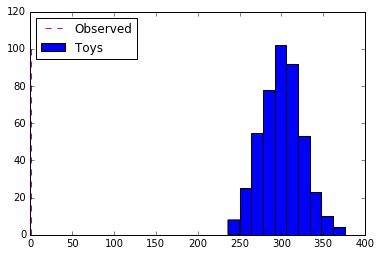

In [76]:
f = ur.open('higgsCombineObs.GoodnessOfFit.mH120.1.root')
s_obs = f['limit']['limit'].array()[0]

s_toys = []
for name_toys in glob('higgsCombineToys.GoodnessOfFit.*.root'):
    f = ur.open(name_toys)
    s_toys += list(f['limit']['limit'].array())

content, center, _ = plt.hist(s_toys, label='Toys')
plt.plot([s_obs, s_obs], [0, np.max(content)], 'm--', label='Observed')
plt.legend(loc='best')

p_val = np.sum(s_toys > s_obs)/float(len(s_toys))
print 'p-value: {:.1f}%'.format(100*p_val)
if p_val < 0.01: print p_val

In [77]:
os.system('mv *.root {}/'.format(outdir))

0